In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

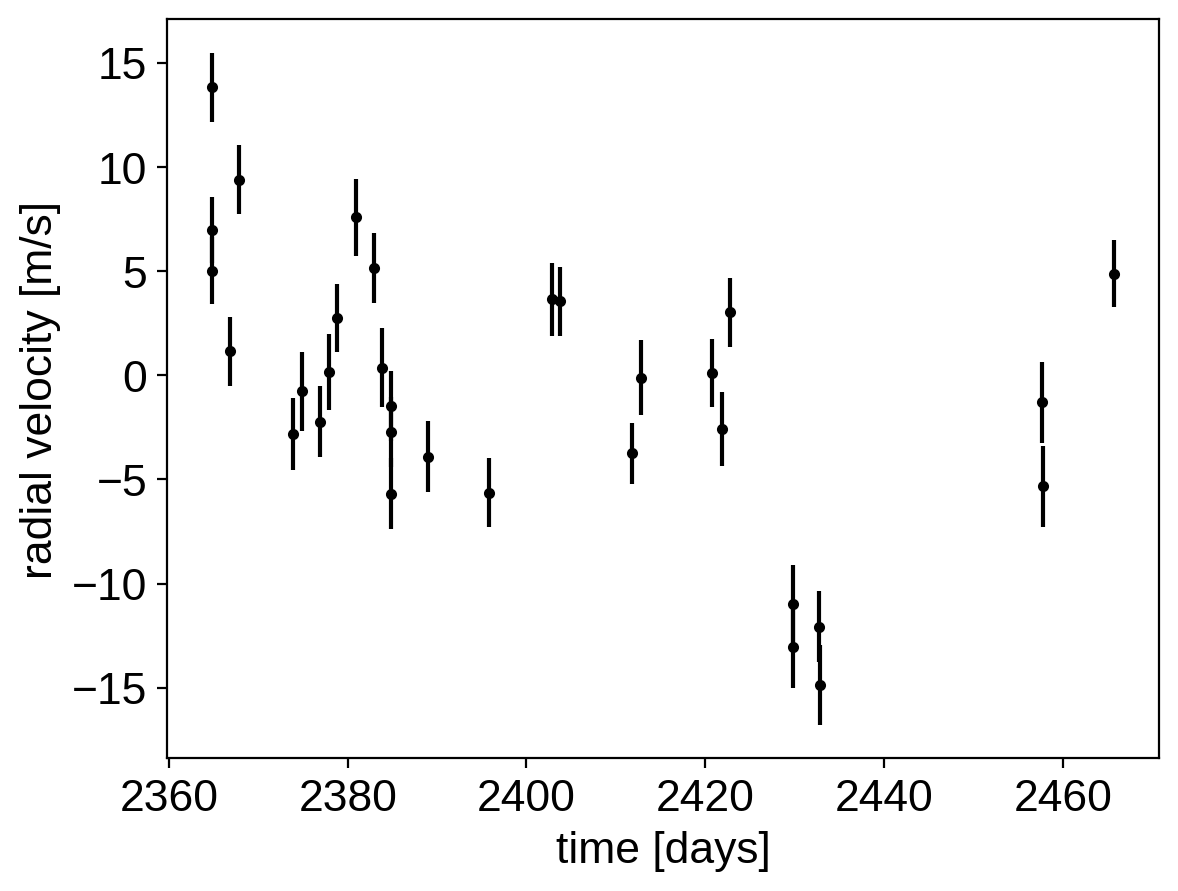

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


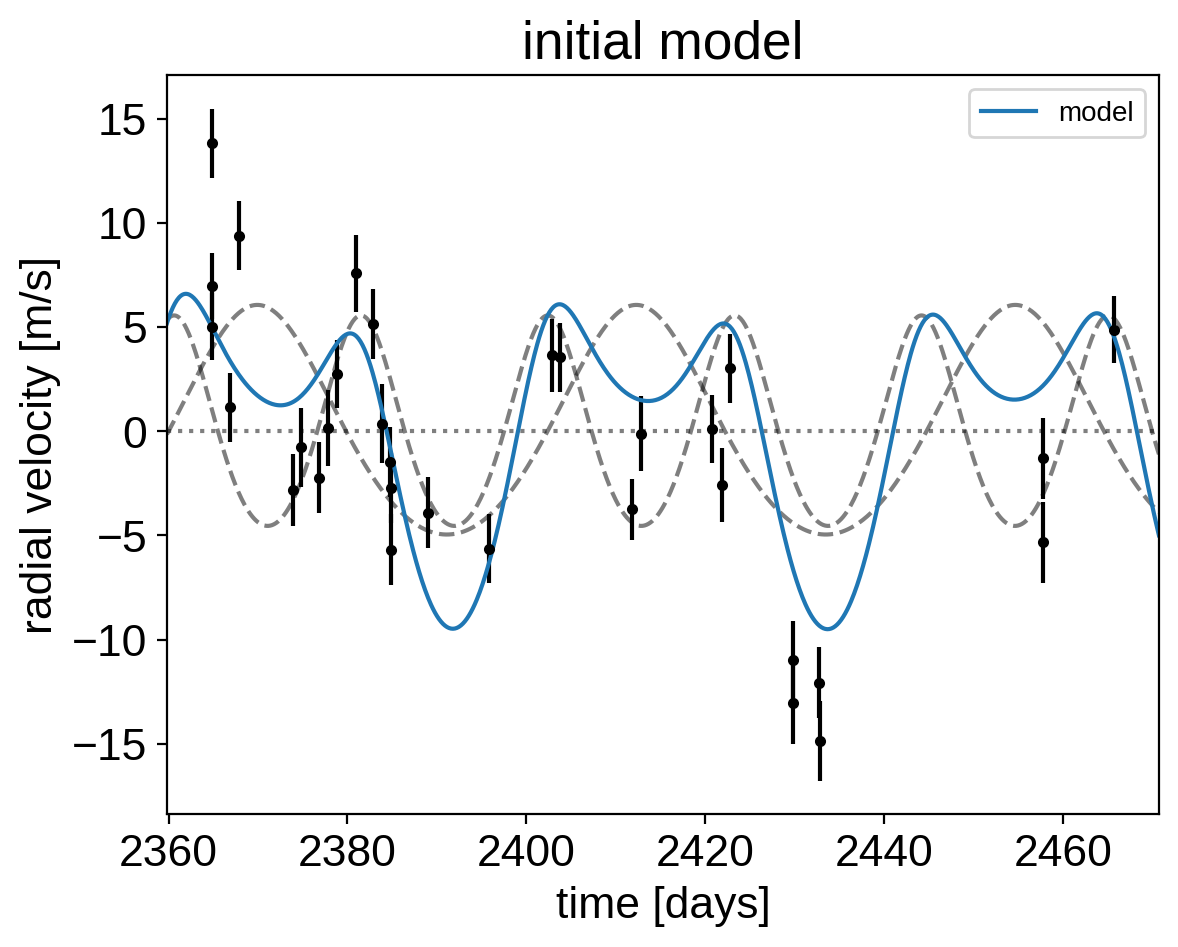

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [7]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 452.02it/s, logp=-7.973266e+01]

2it [00:00, 537.77it/s, logp=-5.305392e+06]

3it [00:00, 621.47it/s, logp=-7.966783e+01]

4it [00:00, 641.43it/s, logp=-7.953812e+01]

5it [00:00, 696.17it/s, logp=-7.904438e+01]

6it [00:00, 760.27it/s, logp=-7.747076e+01]

7it [00:00, 800.72it/s, logp=-7.344108e+01]

8it [00:00, 834.73it/s, logp=-6.722892e+01]

9it [00:00, 851.87it/s, logp=-6.484820e+01]

10it [00:00, 872.36it/s, logp=-6.484820e+01]

11it [00:00, 893.42it/s, logp=-6.484820e+01]

12it [00:03,  3.46it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 534.99it/s, logp=-6.484820e+01]

2it [00:00, 593.51it/s, logp=-4.990134e+09]

3it [00:00, 661.49it/s, logp=-6.484832e+01]

4it [00:00, 708.44it/s, logp=-6.484777e+01]

5it [00:00, 661.81it/s, logp=-6.519268e+01]

6it [00:00, 700.80it/s, logp=-6.484777e+01]

7it [00:00, 721.84it/s, logp=-6.484777e+01]

8it [00:00, 722.63it/s, logp=-6.484776e+01]

9it [00:00, 733.75it/s, logp=-6.484774e+01]

10it [00:00, 756.79it/s, logp=-6.484767e+01]

11it [00:00, 772.03it/s, logp=-6.484739e+01]

12it [00:00, 787.66it/s, logp=-6.484633e+01]

13it [00:00, 768.84it/s, logp=-6.484353e+01]

14it [00:00, 776.67it/s, logp=-6.483426e+01]

15it [00:00, 776.32it/s, logp=-6.481055e+01]

16it [00:00, 781.41it/s, logp=-6.472940e+01]

17it [00:00, 774.17it/s, logp=-6.451928e+01]

18it [00:00, 780.78it/s, logp=-6.371170e+01]

19it [00:00, 789.39it/s, logp=-6.096678e+01]

20it [00:00, 790.59it/s, logp=-5.708652e+01]

21it [00:00, 790.01it/s, logp=-5.027536e+01]

22it [00:00, 794.03it/s, logp=-2.386568e+02]

23it [00:00, 801.04it/s, logp=-4.912172e+01]

24it [00:00, 780.89it/s, logp=-4.707357e+01]

25it [00:00, 781.42it/s, logp=-4.319328e+01]

26it [00:00, 776.70it/s, logp=-3.608487e+01]

27it [00:00, 778.05it/s, logp=-2.498567e+01]

28it [00:00, 776.85it/s, logp=-2.442071e+01]

29it [00:00, 776.68it/s, logp=-2.333036e+01]

30it [00:00, 784.01it/s, logp=-2.011091e+01]

31it [00:00, 785.90it/s, logp=-1.751350e+01]

32it [00:00, 787.64it/s, logp=-1.714559e+01]

33it [00:00, 789.99it/s, logp=-1.693796e+01]

34it [00:00, 792.68it/s, logp=-1.684943e+01]

35it [00:00, 786.86it/s, logp=-1.676095e+01]

36it [00:00, 790.94it/s, logp=-1.673569e+01]

37it [00:00, 793.98it/s, logp=-1.672214e+01]

38it [00:00, 792.79it/s, logp=-1.670758e+01]

39it [00:00, 787.99it/s, logp=-1.668064e+01]

40it [00:00, 789.20it/s, logp=-1.662858e+01]

41it [00:00, 791.25it/s, logp=-1.658058e+01]

42it [00:00, 791.19it/s, logp=-1.655728e+01]

43it [00:00, 791.29it/s, logp=-1.662929e+01]

44it [00:00, 796.67it/s, logp=-1.647872e+01]

45it [00:00, 799.80it/s, logp=-1.635178e+01]

46it [00:00, 801.40it/s, logp=-1.613280e+01]

47it [00:00, 805.04it/s, logp=-1.577352e+01]

48it [00:00, 806.42it/s, logp=-1.525205e+01]

49it [00:00, 800.20it/s, logp=-1.849895e+01]

50it [00:00, 803.84it/s, logp=-1.514689e+01]

51it [00:00, 802.97it/s, logp=-1.501721e+01]

52it [00:00, 805.38it/s, logp=-1.496658e+01]

53it [00:00, 802.90it/s, logp=-1.495457e+01]

54it [00:00, 798.68it/s, logp=-1.494704e+01]

55it [00:00, 798.04it/s, logp=-1.494509e+01]

56it [00:00, 797.73it/s, logp=-1.494181e+01]

57it [00:00, 797.22it/s, logp=-1.493619e+01]

58it [00:00, 798.34it/s, logp=-1.492655e+01]

59it [00:00, 800.04it/s, logp=-1.491151e+01]

60it [00:00, 801.77it/s, logp=-1.489345e+01]

61it [00:00, 803.53it/s, logp=-1.486580e+01]

62it [00:00, 805.65it/s, logp=-1.483881e+01]

63it [00:00, 802.60it/s, logp=-1.479783e+01]

64it [00:00, 804.48it/s, logp=-1.475797e+01]

65it [00:00, 805.11it/s, logp=-1.470224e+01]

66it [00:00, 805.88it/s, logp=-1.466581e+01]

67it [00:00, 803.74it/s, logp=-1.465792e+01]

68it [00:00, 800.02it/s, logp=-1.460984e+01]

69it [00:00, 794.51it/s, logp=-1.453216e+01]

70it [00:00, 793.38it/s, logp=-1.441150e+01]

71it [00:00, 794.86it/s, logp=-1.431230e+01]

72it [00:00, 788.55it/s, logp=-1.436794e+01]

73it [00:00, 787.29it/s, logp=-1.429690e+01]

74it [00:00, 789.02it/s, logp=-1.428194e+01]

75it [00:00, 787.43it/s, logp=-1.427769e+01]

76it [00:00, 782.49it/s, logp=-1.427703e+01]

77it [00:00, 782.29it/s, logp=-1.427688e+01]

78it [00:00, 781.83it/s, logp=-1.427678e+01]

79it [00:00, 787.60it/s, logp=-1.427678e+01]

79it [00:00, 787.60it/s, logp=-1.427677e+01]

80it [00:00, 787.60it/s, logp=-1.427676e+01]

81it [00:00, 787.60it/s, logp=-1.427676e+01]

82it [00:00, 787.60it/s, logp=-1.427676e+01]

83it [00:00, 787.60it/s, logp=-1.427676e+01]

84it [00:00, 787.60it/s, logp=-1.427676e+01]

85it [00:00, 787.60it/s, logp=-1.427676e+01]

86it [00:00, 787.60it/s, logp=-1.427676e+01]

87it [00:00, 787.60it/s, logp=-1.427676e+01]

88it [00:00, 787.60it/s, logp=-1.427676e+01]

89it [00:00, 787.60it/s, logp=-1.427676e+01]

90it [00:00, 185.29it/s, logp=-1.427676e+01]


message: Desired error not necessarily achieved due to precision loss.
logp: -64.8482026233154 -> -14.276760262380932


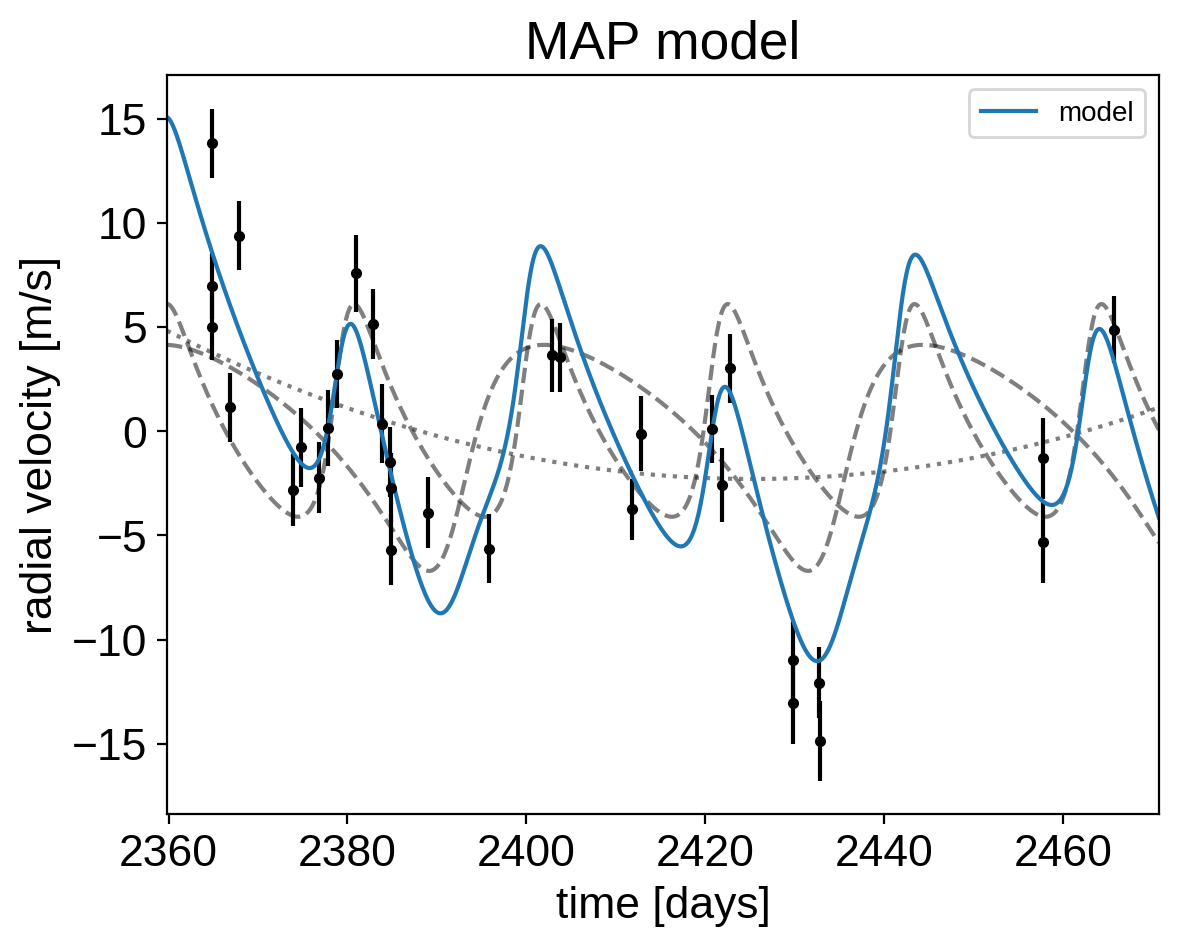

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [9]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/16000 [00:00<03:02, 87.54draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/16000 [00:00<05:46, 46.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/16000 [00:00<07:45, 34.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 20/16000 [00:00<08:10, 32.60draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/16000 [00:00<10:06, 26.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 26/16000 [00:00<09:46, 27.25draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/16000 [00:01<11:08, 23.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/16000 [00:01<10:30, 25.31draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/16000 [00:01<11:40, 22.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/16000 [00:01<11:03, 24.05draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/16000 [00:01<12:28, 21.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 45/16000 [00:01<12:27, 21.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/16000 [00:01<12:22, 21.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/16000 [00:02<12:13, 21.74draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/16000 [00:02<12:15, 21.69draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/16000 [00:02<12:07, 21.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 65/16000 [00:02<12:13, 21.73draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/16000 [00:02<12:11, 21.79draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 72/16000 [00:02<11:15, 23.59draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/16000 [00:03<12:17, 21.59draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 78/16000 [00:03<11:40, 22.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 81/16000 [00:03<12:16, 21.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/16000 [00:03<11:34, 22.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 87/16000 [00:03<12:17, 21.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/16000 [00:03<11:35, 22.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/16000 [00:03<12:29, 21.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/16000 [00:04<11:31, 22.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/16000 [00:04<12:16, 21.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/16000 [00:04<11:45, 22.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 105/16000 [00:04<13:09, 20.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/16000 [00:04<12:09, 21.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/16000 [00:04<12:54, 20.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/16000 [00:04<12:37, 20.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/16000 [00:05<12:11, 21.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/16000 [00:05<12:00, 22.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 127/16000 [00:05<11:56, 22.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/16000 [00:05<11:13, 23.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 133/16000 [00:05<12:12, 21.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/16000 [00:05<11:14, 23.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 139/16000 [00:06<12:16, 21.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 142/16000 [00:06<11:14, 23.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 145/16000 [00:06<12:12, 21.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/16000 [00:06<12:06, 21.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 153/16000 [00:06<11:51, 22.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/16000 [00:06<11:54, 22.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 161/16000 [00:06<11:46, 22.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 165/16000 [00:07<11:53, 22.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 169/16000 [00:07<11:48, 22.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 173/16000 [00:07<11:53, 22.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 177/16000 [00:07<11:38, 22.66draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 180/16000 [00:07<10:47, 24.43draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/16000 [00:07<11:43, 22.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/16000 [00:08<10:57, 24.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 189/16000 [00:08<11:12, 23.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 192/16000 [00:08<10:52, 24.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 195/16000 [00:08<11:30, 22.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 198/16000 [00:08<11:15, 23.39draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 201/16000 [00:08<11:51, 22.20draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 204/16000 [00:08<11:30, 22.86draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 207/16000 [00:09<11:55, 22.08draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 210/16000 [00:09<11:33, 22.78draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 213/16000 [00:09<11:45, 22.36draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 216/16000 [00:09<11:34, 22.73draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 219/16000 [00:09<11:47, 22.30draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 222/16000 [00:09<11:43, 22.44draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 225/16000 [00:09<11:45, 22.37draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 228/16000 [00:09<11:48, 22.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 231/16000 [00:10<11:58, 21.95draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 234/16000 [00:10<11:30, 22.84draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 237/16000 [00:10<11:55, 22.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 240/16000 [00:10<11:36, 22.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/16000 [00:10<12:52, 20.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 246/16000 [00:10<11:42, 22.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/16000 [00:10<12:29, 21.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 252/16000 [00:11<11:28, 22.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 255/16000 [00:11<12:14, 21.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 259/16000 [00:11<12:02, 21.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 263/16000 [00:11<11:47, 22.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 267/16000 [00:11<11:42, 22.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/16000 [00:11<11:45, 22.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 274/16000 [00:11<10:52, 24.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/16000 [00:12<12:06, 21.64draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/16000 [00:12<12:03, 21.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/16000 [00:12<11:58, 21.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/16000 [00:12<11:43, 22.32draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 292/16000 [00:12<10:53, 24.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 295/16000 [00:12<11:57, 21.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 298/16000 [00:13<11:09, 23.45draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 301/16000 [00:13<11:54, 21.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 304/16000 [00:13<13:34, 19.28draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 307/16000 [00:13<15:20, 17.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/16000 [00:13<18:16, 14.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 311/16000 [00:14<20:20, 12.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 313/16000 [00:14<18:48, 13.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 317/16000 [00:14<16:42, 15.64draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 321/16000 [00:14<15:19, 17.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 325/16000 [00:14<14:10, 18.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 329/16000 [00:14<13:21, 19.54draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 333/16000 [00:15<12:51, 20.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 337/16000 [00:15<12:27, 20.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 341/16000 [00:15<12:08, 21.50draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 344/16000 [00:15<11:09, 23.37draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/16000 [00:15<11:24, 22.88draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 350/16000 [00:15<11:13, 23.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 353/16000 [00:15<11:42, 22.27draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 356/16000 [00:16<11:06, 23.48draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 359/16000 [00:16<11:46, 22.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 363/16000 [00:16<11:40, 22.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 367/16000 [00:16<11:36, 22.44draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/16000 [00:16<10:50, 24.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/16000 [00:16<11:04, 23.51draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/16000 [00:16<10:28, 24.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/16000 [00:17<11:08, 23.37draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/16000 [00:17<10:58, 23.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 386/16000 [00:17<11:40, 22.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 390/16000 [00:17<10:49, 24.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 393/16000 [00:17<11:03, 23.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 396/16000 [00:17<10:55, 23.81draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 400/16000 [00:17<11:02, 23.54draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 403/16000 [00:18<22:52, 11.37draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 405/16000 [00:18<20:15, 12.83draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 407/16000 [00:18<18:35, 13.98draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 410/16000 [00:18<16:17, 15.95draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 412/16000 [00:19<21:43, 11.96draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 414/16000 [00:19<22:12, 11.69draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 417/16000 [00:19<18:09, 14.31draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 419/16000 [00:19<17:47, 14.59draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 421/16000 [00:19<20:37, 12.59draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 425/16000 [00:19<16:37, 15.62draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 432/16000 [00:19<13:37, 19.03draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 438/16000 [00:20<10:56, 23.69draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 443/16000 [00:20<10:15, 25.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 447/16000 [00:20<11:05, 23.39draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 452/16000 [00:20<09:23, 27.59draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 460/16000 [00:20<07:52, 32.92draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 469/16000 [00:20<06:23, 40.50draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 479/16000 [00:20<05:19, 48.55draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 489/16000 [00:21<04:36, 56.11draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 498/16000 [00:21<04:12, 61.34draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 509/16000 [00:21<03:46, 68.47draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 522/16000 [00:21<03:15, 79.03draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 533/16000 [00:21<03:04, 84.01draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 547/16000 [00:21<02:45, 93.59draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 562/16000 [00:21<02:28, 104.14draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 577/16000 [00:21<02:14, 114.38draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 592/16000 [00:21<02:07, 120.55draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 605/16000 [00:22<02:18, 111.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 617/16000 [00:22<02:27, 104.61draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 629/16000 [00:22<02:23, 107.05draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 641/16000 [00:22<02:26, 104.88draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 652/16000 [00:22<02:37, 97.34draws/s] 

Sampling 2 chains, 0 divergences:   4%|▍         | 663/16000 [00:22<02:34, 99.34draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 677/16000 [00:22<02:22, 107.31draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 689/16000 [00:22<02:35, 98.34draws/s] 

Sampling 2 chains, 0 divergences:   4%|▍         | 700/16000 [00:23<03:11, 79.93draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 709/16000 [00:23<03:16, 77.87draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 718/16000 [00:23<03:15, 78.34draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 727/16000 [00:23<03:23, 74.98draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 735/16000 [00:23<03:27, 73.40draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 743/16000 [00:23<03:32, 71.81draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 751/16000 [00:23<03:37, 69.96draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 761/16000 [00:23<03:19, 76.39draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 772/16000 [00:24<03:01, 84.01draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 781/16000 [00:24<03:07, 81.26draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 790/16000 [00:24<03:09, 80.33draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 799/16000 [00:24<03:10, 79.68draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 810/16000 [00:24<02:57, 85.43draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 820/16000 [00:24<02:51, 88.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 830/16000 [00:24<02:53, 87.48draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 841/16000 [00:24<02:43, 92.74draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 856/16000 [00:24<02:25, 103.96draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 872/16000 [00:25<02:12, 114.56draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 890/16000 [00:25<01:59, 126.25draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 908/16000 [00:25<01:49, 137.52draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 926/16000 [00:25<01:43, 145.60draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 942/16000 [00:25<01:45, 142.46draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 957/16000 [00:25<01:45, 142.86draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 972/16000 [00:25<01:47, 140.12draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 987/16000 [00:25<01:48, 138.70draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1002/16000 [00:25<01:51, 134.93draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1017/16000 [00:25<01:48, 138.08draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1031/16000 [00:26<02:11, 113.97draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1044/16000 [00:26<02:21, 105.89draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1056/16000 [00:26<02:30, 98.98draws/s] 

Sampling 2 chains, 0 divergences:   7%|▋         | 1067/16000 [00:26<02:31, 98.42draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1078/16000 [00:26<02:30, 99.11draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1089/16000 [00:26<02:31, 98.20draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1100/16000 [00:26<02:32, 97.79draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1110/16000 [00:26<02:31, 98.43draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1120/16000 [00:27<02:56, 84.15draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1129/16000 [00:27<03:17, 75.22draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1137/16000 [00:27<03:21, 73.73draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1145/16000 [00:27<03:26, 72.11draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1153/16000 [00:27<03:21, 73.66draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1164/16000 [00:27<03:08, 78.89draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1175/16000 [00:27<02:52, 85.88draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1186/16000 [00:27<02:44, 90.23draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1198/16000 [00:28<02:33, 96.14draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1210/16000 [00:28<02:28, 99.77draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1221/16000 [00:28<02:47, 88.36draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1231/16000 [00:28<02:45, 89.33draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1242/16000 [00:28<02:36, 94.40draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1254/16000 [00:28<02:28, 99.20draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1266/16000 [00:28<02:24, 102.10draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1278/16000 [00:28<02:18, 106.36draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1289/16000 [00:28<02:19, 105.26draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1300/16000 [00:29<02:18, 105.82draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1311/16000 [00:29<02:19, 105.08draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1322/16000 [00:29<02:23, 102.32draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1335/16000 [00:29<02:14, 108.96draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1347/16000 [00:29<02:13, 109.99draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1359/16000 [00:29<02:12, 110.51draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1372/16000 [00:29<02:07, 114.96draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1384/16000 [00:29<02:09, 112.98draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1396/16000 [00:29<02:10, 111.58draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1409/16000 [00:30<02:05, 115.96draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1423/16000 [00:30<02:00, 120.97draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1438/16000 [00:30<01:53, 127.80draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1451/16000 [00:30<01:56, 124.74draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1466/16000 [00:30<01:50, 131.21draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1481/16000 [00:30<01:47, 135.21draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1497/16000 [00:30<01:43, 139.75draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1513/16000 [00:30<01:41, 143.15draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1528/16000 [00:30<01:42, 141.30draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1543/16000 [00:30<01:43, 139.02draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1558/16000 [00:31<01:42, 140.95draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1574/16000 [00:31<01:39, 144.43draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1589/16000 [00:31<01:39, 144.94draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1605/16000 [00:31<01:37, 147.83draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1623/16000 [00:31<01:32, 154.88draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1641/16000 [00:31<01:29, 160.37draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1658/16000 [00:31<01:28, 161.36draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1675/16000 [00:31<01:29, 160.14draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1692/16000 [00:31<01:40, 141.68draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1707/16000 [00:32<01:53, 125.42draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1721/16000 [00:32<02:02, 116.49draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1734/16000 [00:32<02:12, 107.82draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1746/16000 [00:32<02:10, 108.97draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1758/16000 [00:32<02:09, 109.68draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1773/16000 [00:32<01:59, 118.91draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1786/16000 [00:32<02:09, 109.82draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1798/16000 [00:32<02:06, 112.17draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1811/16000 [00:33<02:02, 116.24draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1823/16000 [00:33<02:04, 113.51draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1837/16000 [00:33<02:00, 117.36draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1853/16000 [00:33<01:51, 126.51draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1867/16000 [00:33<01:49, 128.96draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1883/16000 [00:33<01:43, 136.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1898/16000 [00:33<01:41, 138.56draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1914/16000 [00:33<01:40, 140.05draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1929/16000 [00:33<01:47, 130.43draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1943/16000 [00:34<01:54, 123.06draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1956/16000 [00:34<02:11, 106.74draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1968/16000 [00:34<02:36, 89.67draws/s] 

Sampling 2 chains, 0 divergences:  12%|█▏        | 1978/16000 [00:34<02:57, 78.85draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1987/16000 [00:34<03:03, 76.45draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1996/16000 [00:34<03:02, 76.68draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2005/16000 [00:34<03:07, 74.53draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2016/16000 [00:35<02:55, 79.74draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2027/16000 [00:35<02:41, 86.33draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2039/16000 [00:35<02:31, 92.37draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2050/16000 [00:35<02:26, 95.46draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2060/16000 [00:35<02:36, 89.05draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2070/16000 [00:35<02:43, 85.06draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2079/16000 [00:35<02:42, 85.43draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2088/16000 [00:35<02:42, 85.80draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2097/16000 [00:35<02:44, 84.31draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2106/16000 [00:36<02:44, 84.68draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2119/16000 [00:36<02:28, 93.27draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2133/16000 [00:36<02:15, 102.68draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2146/16000 [00:36<02:07, 108.40draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2160/16000 [00:36<01:59, 115.88draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2173/16000 [00:36<01:58, 116.95draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2187/16000 [00:36<01:53, 121.58draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2201/16000 [00:36<01:49, 125.86draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2215/16000 [00:36<01:46, 129.00draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2230/16000 [00:37<01:42, 133.74draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2247/16000 [00:37<01:37, 140.42draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2262/16000 [00:37<01:36, 142.60draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2277/16000 [00:37<01:35, 143.51draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2294/16000 [00:37<01:32, 147.82draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2309/16000 [00:37<01:32, 148.01draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2324/16000 [00:37<01:39, 137.52draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2340/16000 [00:37<01:35, 143.33draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2359/16000 [00:37<01:29, 152.69draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2375/16000 [00:37<01:30, 150.94draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2391/16000 [00:38<01:30, 150.21draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2407/16000 [00:38<01:44, 130.24draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2421/16000 [00:38<01:48, 125.11draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2434/16000 [00:38<02:03, 110.20draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2446/16000 [00:38<02:19, 97.33draws/s] 

Sampling 2 chains, 0 divergences:  15%|█▌        | 2457/16000 [00:38<02:25, 93.25draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2467/16000 [00:38<02:29, 90.59draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2477/16000 [00:39<02:28, 91.06draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2487/16000 [00:39<02:32, 88.87draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2499/16000 [00:39<02:20, 96.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2510/16000 [00:39<02:18, 97.53draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2522/16000 [00:39<02:13, 100.65draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2536/16000 [00:39<02:05, 107.68draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2551/16000 [00:39<01:54, 117.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2566/16000 [00:39<01:47, 124.53draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2581/16000 [00:39<01:44, 128.65draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2596/16000 [00:39<01:40, 133.66draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2612/16000 [00:40<01:36, 138.45draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2631/16000 [00:40<01:29, 148.89draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2647/16000 [00:40<01:30, 147.41draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2663/16000 [00:40<01:31, 145.49draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2678/16000 [00:40<01:35, 139.24draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2693/16000 [00:40<01:46, 124.69draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2706/16000 [00:40<01:52, 117.82draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2719/16000 [00:40<01:52, 118.49draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2735/16000 [00:41<01:45, 125.59draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2751/16000 [00:41<01:40, 132.01draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2766/16000 [00:41<01:37, 135.67draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2781/16000 [00:41<01:34, 139.33draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2797/16000 [00:41<01:32, 142.72draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2812/16000 [00:41<01:32, 143.17draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2831/16000 [00:41<01:26, 152.91draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2847/16000 [00:41<01:27, 151.09draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2863/16000 [00:41<01:28, 148.81draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2879/16000 [00:41<01:27, 149.66draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2895/16000 [00:42<01:27, 149.06draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2914/16000 [00:42<01:22, 157.87draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2930/16000 [00:42<01:26, 150.30draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2946/16000 [00:42<01:42, 127.71draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2960/16000 [00:42<01:52, 116.30draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2973/16000 [00:42<01:54, 114.19draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2986/16000 [00:42<01:53, 115.06draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2998/16000 [00:42<01:51, 116.15draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3010/16000 [00:43<02:06, 102.48draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3021/16000 [00:43<02:12, 97.96draws/s] 

Sampling 2 chains, 0 divergences:  19%|█▉        | 3032/16000 [00:43<02:13, 97.21draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3042/16000 [00:43<02:13, 97.33draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3052/16000 [00:43<02:12, 97.60draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3064/16000 [00:43<02:05, 102.91draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3076/16000 [00:43<02:02, 105.32draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3088/16000 [00:43<02:00, 106.89draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3099/16000 [00:43<02:11, 97.85draws/s] 

Sampling 2 chains, 0 divergences:  19%|█▉        | 3110/16000 [00:44<02:51, 75.00draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3119/16000 [00:44<03:04, 69.75draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3127/16000 [00:44<03:21, 63.82draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3135/16000 [00:44<03:13, 66.47draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3143/16000 [00:44<03:10, 67.53draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3151/16000 [00:44<03:02, 70.41draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3162/16000 [00:44<02:43, 78.62draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3173/16000 [00:45<02:31, 84.71draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3185/16000 [00:45<02:20, 91.11draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3196/16000 [00:45<02:15, 94.39draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3207/16000 [00:45<02:09, 98.52draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3219/16000 [00:45<02:03, 103.13draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3230/16000 [00:45<02:03, 103.44draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3241/16000 [00:45<02:03, 103.67draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3253/16000 [00:45<02:00, 105.70draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3265/16000 [00:45<01:58, 107.61draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3277/16000 [00:46<01:55, 109.90draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3289/16000 [00:46<01:57, 108.24draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3303/16000 [00:46<01:50, 115.30draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3319/16000 [00:46<01:41, 125.31draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3332/16000 [00:46<01:42, 123.95draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3345/16000 [00:46<01:41, 124.10draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3358/16000 [00:46<01:42, 122.89draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3371/16000 [00:46<01:43, 121.63draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3384/16000 [00:46<01:48, 115.80draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3396/16000 [00:46<01:48, 115.75draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3408/16000 [00:47<01:54, 109.83draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3420/16000 [00:47<01:54, 110.01draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3432/16000 [00:47<01:57, 106.73draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3443/16000 [00:47<01:58, 105.69draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3457/16000 [00:47<01:50, 113.36draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3471/16000 [00:47<01:49, 114.60draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3485/16000 [00:47<01:43, 121.08draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3499/16000 [00:47<01:39, 126.09draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3516/16000 [00:47<01:32, 135.42draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3532/16000 [00:48<01:28, 140.33draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3547/16000 [00:48<01:27, 142.92draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3565/16000 [00:48<01:22, 150.99draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3583/16000 [00:48<01:18, 157.27draws/s]

Sampling 2 chains, 0 divergences:  22%|██▎       | 3600/16000 [00:48<01:17, 160.77draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3619/16000 [00:48<01:14, 165.90draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3636/16000 [00:48<01:15, 164.59draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3653/16000 [00:48<01:16, 161.89draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3670/16000 [00:48<01:15, 162.58draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3690/16000 [00:49<01:11, 171.30draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3708/16000 [00:49<01:13, 166.85draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3728/16000 [00:49<01:10, 172.92draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3747/16000 [00:49<01:08, 177.63draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3765/16000 [00:49<01:12, 169.52draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3783/16000 [00:49<01:11, 171.16draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3801/16000 [00:49<01:11, 171.80draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3819/16000 [00:49<01:11, 171.42draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3837/16000 [00:49<01:10, 171.98draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3855/16000 [00:49<01:10, 171.91draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3875/16000 [00:50<01:07, 178.40draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3893/16000 [00:50<01:08, 176.79draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3912/16000 [00:50<01:07, 178.37draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3930/16000 [00:50<01:12, 166.67draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3947/16000 [00:50<01:16, 156.58draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3963/16000 [00:50<01:17, 155.73draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3979/16000 [00:50<01:16, 156.74draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3997/16000 [00:50<01:14, 161.78draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4016/16000 [00:50<01:10, 168.91draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4035/16000 [00:51<01:08, 174.07draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4055/16000 [00:51<01:06, 180.15draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4074/16000 [00:51<01:06, 179.38draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4093/16000 [00:51<01:08, 173.42draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4111/16000 [00:51<01:11, 166.03draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4128/16000 [00:51<01:17, 153.09draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4144/16000 [00:51<01:21, 145.59draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4159/16000 [00:51<01:21, 144.41draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4174/16000 [00:51<01:24, 139.63draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4189/16000 [00:52<01:25, 138.08draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4203/16000 [00:52<01:30, 129.71draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4217/16000 [00:52<01:43, 113.56draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4229/16000 [00:52<01:43, 114.21draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4242/16000 [00:52<01:39, 117.62draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4255/16000 [00:52<01:43, 113.79draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4267/16000 [00:52<01:42, 114.87draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4282/16000 [00:52<01:36, 121.91draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4297/16000 [00:52<01:32, 126.69draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4310/16000 [00:53<01:33, 124.93draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4324/16000 [00:53<01:30, 128.46draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4339/16000 [00:53<01:26, 134.07draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4354/16000 [00:53<01:25, 136.69draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4370/16000 [00:53<01:22, 140.70draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4387/16000 [00:53<01:19, 146.60draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4404/16000 [00:53<01:15, 152.74draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4421/16000 [00:53<01:14, 154.82draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4437/16000 [00:53<01:16, 151.07draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4453/16000 [00:54<01:25, 135.15draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4469/16000 [00:54<01:23, 138.34draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4484/16000 [00:54<01:24, 136.17draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4498/16000 [00:54<01:24, 136.04draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4512/16000 [00:54<01:28, 130.44draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4526/16000 [00:54<01:33, 122.79draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4539/16000 [00:54<01:32, 124.27draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4553/16000 [00:54<01:30, 125.99draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4568/16000 [00:54<01:27, 130.49draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4582/16000 [00:55<01:29, 128.01draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4595/16000 [00:55<01:33, 122.30draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4608/16000 [00:55<01:35, 118.91draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4620/16000 [00:55<01:35, 119.15draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4632/16000 [00:55<01:35, 118.58draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4647/16000 [00:55<01:30, 125.34draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4661/16000 [00:55<01:29, 126.41draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4674/16000 [00:55<01:41, 111.77draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4686/16000 [00:56<02:03, 91.43draws/s] 

Sampling 2 chains, 0 divergences:  29%|██▉       | 4697/16000 [00:56<02:18, 81.39draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4706/16000 [00:56<02:37, 71.85draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4714/16000 [00:56<02:42, 69.42draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4722/16000 [00:56<02:45, 67.94draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4731/16000 [00:56<02:33, 73.28draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4741/16000 [00:56<02:25, 77.59draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4751/16000 [00:56<02:18, 81.36draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4761/16000 [00:57<02:11, 85.34draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4770/16000 [00:57<02:11, 85.21draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4780/16000 [00:57<02:13, 83.98draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4790/16000 [00:57<02:07, 87.65draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4801/16000 [00:57<02:01, 92.52draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4811/16000 [00:57<02:01, 92.22draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4823/16000 [00:57<01:55, 96.53draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4833/16000 [00:57<02:01, 92.26draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4843/16000 [00:57<02:00, 92.79draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4854/16000 [00:58<01:55, 96.74draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4864/16000 [00:58<01:59, 93.52draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4874/16000 [00:58<02:06, 88.14draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4884/16000 [00:58<02:02, 90.46draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4895/16000 [00:58<01:57, 94.31draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4905/16000 [00:58<01:59, 92.64draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4916/16000 [00:58<01:55, 95.72draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4927/16000 [00:58<01:53, 97.77draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4937/16000 [00:58<02:00, 91.76draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4949/16000 [00:59<01:53, 97.75draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4960/16000 [00:59<01:50, 100.06draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4971/16000 [00:59<01:48, 101.93draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4983/16000 [00:59<01:44, 105.12draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4996/16000 [00:59<01:40, 109.64draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5008/16000 [00:59<01:46, 103.39draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5019/16000 [00:59<01:53, 96.51draws/s] 

Sampling 2 chains, 0 divergences:  31%|███▏      | 5030/16000 [00:59<01:51, 98.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5041/16000 [00:59<01:49, 100.40draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5052/16000 [01:00<01:51, 98.31draws/s] 

Sampling 2 chains, 0 divergences:  32%|███▏      | 5063/16000 [01:00<01:48, 101.16draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5074/16000 [01:00<01:56, 93.52draws/s] 

Sampling 2 chains, 0 divergences:  32%|███▏      | 5084/16000 [01:00<01:54, 95.24draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5094/16000 [01:00<01:56, 93.38draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5105/16000 [01:00<01:55, 94.67draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5117/16000 [01:00<01:48, 100.53draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5129/16000 [01:00<01:45, 103.08draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5145/16000 [01:00<01:35, 113.34draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5160/16000 [01:01<01:28, 121.90draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5174/16000 [01:01<01:26, 124.53draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5188/16000 [01:01<01:24, 127.60draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5202/16000 [01:01<01:24, 127.96draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5215/16000 [01:01<01:25, 126.26draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5228/16000 [01:01<01:29, 120.95draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5241/16000 [01:01<01:31, 117.38draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5253/16000 [01:01<01:41, 105.75draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5264/16000 [01:02<01:51, 96.04draws/s] 

Sampling 2 chains, 0 divergences:  33%|███▎      | 5274/16000 [01:02<01:53, 94.27draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5284/16000 [01:02<01:54, 93.99draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5295/16000 [01:02<01:50, 96.59draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5305/16000 [01:02<01:55, 92.58draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5316/16000 [01:02<01:51, 95.82draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5327/16000 [01:02<01:48, 97.97draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5339/16000 [01:02<01:43, 103.34draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5350/16000 [01:02<01:41, 105.12draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5363/16000 [01:02<01:37, 109.15draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5378/16000 [01:03<01:30, 117.75draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5392/16000 [01:03<01:27, 121.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5405/16000 [01:03<01:28, 119.23draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5418/16000 [01:03<01:32, 114.61draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5433/16000 [01:03<01:25, 123.13draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5449/16000 [01:03<01:20, 130.72draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5464/16000 [01:03<01:18, 133.55draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5478/16000 [01:03<01:19, 133.05draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5492/16000 [01:03<01:23, 126.16draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5505/16000 [01:04<01:26, 120.68draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5518/16000 [01:04<01:29, 116.92draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5530/16000 [01:04<01:29, 117.59draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5542/16000 [01:04<01:30, 115.83draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5554/16000 [01:04<01:31, 114.30draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5566/16000 [01:04<01:35, 109.54draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5578/16000 [01:04<01:41, 103.00draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5590/16000 [01:04<01:39, 104.92draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5601/16000 [01:04<01:38, 105.89draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5612/16000 [01:05<01:38, 105.83draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5623/16000 [01:05<01:39, 104.69draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5635/16000 [01:05<01:36, 107.40draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5647/16000 [01:05<01:35, 108.17draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5659/16000 [01:05<01:34, 109.18draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5670/16000 [01:05<01:37, 105.61draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5681/16000 [01:05<01:37, 105.42draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5692/16000 [01:05<01:40, 102.61draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5703/16000 [01:05<01:40, 102.21draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5714/16000 [01:06<01:45, 97.11draws/s] 

Sampling 2 chains, 0 divergences:  36%|███▌      | 5724/16000 [01:06<02:00, 85.22draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5733/16000 [01:06<02:05, 82.05draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5742/16000 [01:06<02:06, 80.80draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5751/16000 [01:06<02:05, 81.97draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5761/16000 [01:06<02:01, 83.97draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5771/16000 [01:06<01:59, 85.58draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5782/16000 [01:06<01:52, 91.22draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5792/16000 [01:07<01:53, 89.77draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5803/16000 [01:07<01:50, 92.28draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5814/16000 [01:07<01:46, 96.05draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5825/16000 [01:07<01:43, 98.46draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5837/16000 [01:07<01:40, 101.12draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5848/16000 [01:07<01:45, 96.61draws/s] 

Sampling 2 chains, 0 divergences:  37%|███▋      | 5860/16000 [01:07<01:39, 101.55draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5872/16000 [01:07<01:36, 104.91draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5883/16000 [01:07<01:36, 104.56draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5895/16000 [01:07<01:33, 108.03draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5910/16000 [01:08<01:26, 116.41draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5924/16000 [01:08<01:22, 122.49draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5940/16000 [01:08<01:17, 129.59draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5957/16000 [01:08<01:12, 138.56draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5974/16000 [01:08<01:09, 145.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5989/16000 [01:08<01:08, 145.19draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6004/16000 [01:08<01:10, 141.34draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6019/16000 [01:08<01:10, 141.61draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6038/16000 [01:08<01:05, 152.63draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6055/16000 [01:09<01:03, 157.34draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6072/16000 [01:09<01:01, 160.19draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6089/16000 [01:09<01:03, 155.92draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6105/16000 [01:09<01:03, 155.47draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6122/16000 [01:09<01:03, 156.76draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6138/16000 [01:09<01:04, 154.05draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6154/16000 [01:09<01:06, 148.95draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6170/16000 [01:09<01:05, 149.39draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6186/16000 [01:09<01:05, 150.75draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6204/16000 [01:09<01:02, 155.55draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6221/16000 [01:10<01:01, 159.41draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6238/16000 [01:10<01:02, 156.27draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6255/16000 [01:10<01:01, 158.08draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6272/16000 [01:10<01:02, 156.85draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6288/16000 [01:10<01:01, 157.23draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6304/16000 [01:10<01:02, 155.69draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6320/16000 [01:10<01:10, 137.89draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6335/16000 [01:10<01:09, 138.47draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6353/16000 [01:10<01:05, 148.33draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6373/16000 [01:11<01:01, 157.66draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6390/16000 [01:11<01:00, 160.02draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6407/16000 [01:11<01:00, 157.87draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6424/16000 [01:11<01:00, 157.95draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6440/16000 [01:11<01:01, 154.78draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6456/16000 [01:11<01:03, 151.15draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6472/16000 [01:11<01:04, 148.39draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6487/16000 [01:11<01:06, 143.91draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6503/16000 [01:11<01:05, 145.27draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6518/16000 [01:12<01:05, 144.02draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6535/16000 [01:12<01:03, 148.18draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6551/16000 [01:12<01:04, 147.64draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6567/16000 [01:12<01:03, 147.84draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6582/16000 [01:12<01:06, 141.25draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6598/16000 [01:12<01:04, 145.04draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6613/16000 [01:12<01:09, 135.74draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6627/16000 [01:12<01:11, 131.39draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6641/16000 [01:12<01:11, 131.23draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6655/16000 [01:13<01:14, 125.17draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6668/16000 [01:13<01:16, 122.02draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6682/16000 [01:13<01:14, 125.89draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6695/16000 [01:13<01:14, 124.18draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6708/16000 [01:13<01:14, 125.26draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6721/16000 [01:13<01:17, 119.93draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6734/16000 [01:13<01:16, 120.79draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6748/16000 [01:13<01:14, 123.75draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6761/16000 [01:13<01:16, 120.46draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6775/16000 [01:14<01:17, 119.62draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6788/16000 [01:14<01:21, 112.82draws/s]

Sampling 2 chains, 0 divergences:  42%|████▎     | 6800/16000 [01:14<01:20, 113.72draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6813/16000 [01:14<01:18, 117.69draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6826/16000 [01:14<01:17, 118.82draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6839/16000 [01:14<01:16, 119.27draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6851/16000 [01:14<01:17, 118.46draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6864/16000 [01:14<01:16, 119.55draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6878/16000 [01:14<01:13, 124.39draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6896/16000 [01:15<01:06, 136.72draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6913/16000 [01:15<01:02, 144.71draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6929/16000 [01:15<01:01, 147.89draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6945/16000 [01:15<01:03, 143.52draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6960/16000 [01:15<01:03, 142.38draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6975/16000 [01:15<01:02, 144.12draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6991/16000 [01:15<01:00, 147.86draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7007/16000 [01:15<01:00, 149.05draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7023/16000 [01:15<01:00, 149.34draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7040/16000 [01:15<00:58, 153.75draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7056/16000 [01:16<00:57, 154.80draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7072/16000 [01:16<00:57, 154.81draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7089/16000 [01:16<00:56, 158.57draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7105/16000 [01:16<00:58, 151.71draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7121/16000 [01:16<01:00, 147.63draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7137/16000 [01:16<00:59, 148.15draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7152/16000 [01:16<01:00, 146.71draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7167/16000 [01:16<01:01, 142.63draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7182/16000 [01:16<01:01, 142.46draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7197/16000 [01:17<01:05, 133.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7211/16000 [01:17<01:08, 127.49draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7224/16000 [01:17<01:10, 123.96draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7237/16000 [01:17<01:11, 122.19draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7250/16000 [01:17<01:12, 120.72draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7264/16000 [01:17<01:10, 123.46draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7277/16000 [01:17<01:13, 118.77draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7289/16000 [01:17<01:16, 113.16draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7301/16000 [01:17<01:16, 113.84draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7314/16000 [01:18<01:15, 114.52draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7327/16000 [01:18<01:13, 118.28draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7340/16000 [01:18<01:11, 120.54draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7356/16000 [01:18<01:07, 128.75draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7370/16000 [01:18<01:06, 129.43draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7384/16000 [01:18<01:06, 129.95draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7398/16000 [01:18<01:06, 128.65draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7414/16000 [01:18<01:04, 134.07draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7431/16000 [01:18<01:00, 142.20draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7448/16000 [01:19<00:58, 146.99draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7464/16000 [01:19<00:56, 150.11draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7480/16000 [01:19<00:58, 145.82draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7497/16000 [01:19<00:56, 151.34draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7513/16000 [01:19<00:55, 152.67draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7529/16000 [01:19<00:55, 153.66draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7545/16000 [01:19<00:55, 152.80draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7561/16000 [01:19<00:54, 153.99draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7577/16000 [01:19<00:56, 148.38draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7594/16000 [01:20<00:54, 152.91draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7610/16000 [01:20<00:54, 153.29draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7626/16000 [01:20<00:59, 139.98draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7641/16000 [01:20<01:07, 123.23draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7654/16000 [01:20<01:11, 117.34draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7667/16000 [01:20<01:09, 120.55draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7680/16000 [01:20<01:14, 111.32draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7692/16000 [01:20<01:15, 109.38draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7704/16000 [01:20<01:15, 110.52draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7716/16000 [01:21<01:13, 112.53draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7728/16000 [01:21<01:15, 109.88draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7740/16000 [01:21<01:13, 112.00draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7753/16000 [01:21<01:12, 114.37draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7765/16000 [01:21<01:12, 114.00draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7777/16000 [01:21<01:12, 112.92draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7789/16000 [01:21<01:14, 109.52draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7802/16000 [01:21<01:13, 111.77draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7819/16000 [01:21<01:07, 122.09draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7832/16000 [01:22<01:06, 122.84draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7847/16000 [01:22<01:03, 128.50draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7862/16000 [01:22<01:01, 132.23draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7880/16000 [01:22<00:56, 142.59draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7897/16000 [01:22<00:54, 149.21draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7914/16000 [01:22<00:52, 152.83draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7932/16000 [01:22<00:51, 157.27draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7948/16000 [01:22<00:51, 156.89draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7966/16000 [01:22<00:50, 160.44draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7983/16000 [01:23<00:50, 158.40draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7999/16000 [01:23<00:50, 158.82draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8015/16000 [01:23<00:53, 149.52draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8031/16000 [01:23<00:52, 152.08draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8047/16000 [01:23<00:56, 141.33draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8062/16000 [01:23<01:03, 125.62draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8076/16000 [01:23<01:06, 119.02draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8089/16000 [01:23<01:07, 117.58draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8102/16000 [01:23<01:06, 118.23draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8115/16000 [01:24<01:12, 108.70draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8127/16000 [01:24<01:11, 110.80draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8139/16000 [01:24<01:11, 110.51draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8154/16000 [01:24<01:05, 119.24draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8170/16000 [01:24<01:01, 127.78draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8184/16000 [01:24<01:05, 119.29draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8197/16000 [01:24<01:09, 111.87draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8209/16000 [01:24<01:08, 113.73draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8222/16000 [01:25<01:08, 114.35draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8235/16000 [01:25<01:07, 115.44draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8249/16000 [01:25<01:04, 120.50draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8262/16000 [01:25<01:05, 118.22draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8274/16000 [01:25<01:05, 118.63draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8291/16000 [01:25<01:00, 128.14draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8306/16000 [01:25<00:59, 128.97draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8320/16000 [01:25<00:59, 128.57draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8334/16000 [01:25<00:58, 130.03draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8349/16000 [01:25<00:56, 134.55draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8363/16000 [01:26<00:58, 131.43draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8380/16000 [01:26<00:54, 139.60draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8397/16000 [01:26<00:52, 143.68draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8412/16000 [01:26<00:54, 140.40draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8427/16000 [01:26<00:55, 136.92draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8441/16000 [01:26<01:02, 120.31draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8454/16000 [01:26<01:02, 121.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8467/16000 [01:26<01:01, 122.90draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8481/16000 [01:27<00:59, 125.72draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8495/16000 [01:27<00:58, 128.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8508/16000 [01:27<00:59, 125.11draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8521/16000 [01:27<01:00, 122.67draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8534/16000 [01:27<01:04, 116.55draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8546/16000 [01:27<01:03, 116.89draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8558/16000 [01:27<01:06, 111.58draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8571/16000 [01:27<01:05, 112.66draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8583/16000 [01:27<01:04, 114.24draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8596/16000 [01:27<01:03, 117.30draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8608/16000 [01:28<01:04, 114.77draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8622/16000 [01:28<01:01, 120.28draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8635/16000 [01:28<01:00, 122.64draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8648/16000 [01:28<00:59, 123.88draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8664/16000 [01:28<00:55, 131.79draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8680/16000 [01:28<00:53, 137.59draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8697/16000 [01:28<00:51, 142.17draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8712/16000 [01:28<00:52, 138.34draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8728/16000 [01:28<00:51, 142.53draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8743/16000 [01:29<00:52, 137.50draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8757/16000 [01:29<00:52, 138.05draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8771/16000 [01:29<00:52, 137.67draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8785/16000 [01:29<00:55, 130.56draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8799/16000 [01:29<00:54, 131.56draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8815/16000 [01:29<00:52, 135.98draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8832/16000 [01:29<00:50, 142.63draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8849/16000 [01:29<00:48, 147.01draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8866/16000 [01:29<00:47, 151.19draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8882/16000 [01:30<00:47, 150.19draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8898/16000 [01:30<00:53, 132.06draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8914/16000 [01:30<00:52, 135.59draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8928/16000 [01:30<00:53, 131.88draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8942/16000 [01:30<00:53, 132.86draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8956/16000 [01:30<00:54, 129.27draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8970/16000 [01:30<00:55, 127.76draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8984/16000 [01:30<00:53, 130.92draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8999/16000 [01:30<00:52, 134.26draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9016/16000 [01:31<00:49, 141.85draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9032/16000 [01:31<00:47, 145.87draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9047/16000 [01:31<00:47, 145.23draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9062/16000 [01:31<00:47, 145.16draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9077/16000 [01:31<00:49, 141.14draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9092/16000 [01:31<00:48, 143.18draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9107/16000 [01:31<00:48, 141.57draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9122/16000 [01:31<00:48, 140.85draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9137/16000 [01:31<00:50, 135.40draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9151/16000 [01:32<00:52, 131.29draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9165/16000 [01:32<00:51, 133.17draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9179/16000 [01:32<00:50, 134.72draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9194/16000 [01:32<00:49, 137.01draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9208/16000 [01:32<00:50, 135.67draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9225/16000 [01:32<00:48, 140.01draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9242/16000 [01:32<00:46, 145.85draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9258/16000 [01:32<00:46, 144.95draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9274/16000 [01:32<00:46, 145.21draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9289/16000 [01:32<00:46, 145.77draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9304/16000 [01:33<00:47, 142.47draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9319/16000 [01:33<00:52, 128.03draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9334/16000 [01:33<00:51, 130.03draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9348/16000 [01:33<00:52, 125.53draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9364/16000 [01:33<00:50, 132.57draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9378/16000 [01:33<00:49, 134.46draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9394/16000 [01:33<00:47, 138.26draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9408/16000 [01:33<00:48, 136.97draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9422/16000 [01:34<00:51, 126.75draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9435/16000 [01:34<00:53, 123.70draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9451/16000 [01:34<00:50, 130.85draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9465/16000 [01:34<00:49, 131.59draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9479/16000 [01:34<00:50, 129.72draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9493/16000 [01:34<00:51, 125.69draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9506/16000 [01:34<00:52, 122.85draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9521/16000 [01:34<00:50, 128.04draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9536/16000 [01:34<00:49, 131.82draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9550/16000 [01:34<00:48, 132.09draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9565/16000 [01:35<00:47, 135.91draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9581/16000 [01:35<00:45, 141.03draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9597/16000 [01:35<00:44, 144.99draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9612/16000 [01:35<00:47, 134.69draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9627/16000 [01:35<00:46, 136.71draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9641/16000 [01:35<00:47, 133.94draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9656/16000 [01:35<00:46, 135.49draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9670/16000 [01:35<00:46, 135.74draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9686/16000 [01:35<00:44, 141.27draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9701/16000 [01:36<00:44, 142.47draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9716/16000 [01:36<00:45, 137.85draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9730/16000 [01:36<00:48, 129.54draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9744/16000 [01:36<00:47, 132.14draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9761/16000 [01:36<00:44, 140.21draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9776/16000 [01:36<00:43, 142.89draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9791/16000 [01:36<00:43, 143.06draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9806/16000 [01:36<00:44, 140.60draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9822/16000 [01:36<00:43, 143.60draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9838/16000 [01:37<00:42, 144.85draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9854/16000 [01:37<00:41, 147.61draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9869/16000 [01:37<00:43, 142.38draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9885/16000 [01:37<00:41, 146.50draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9900/16000 [01:37<00:41, 146.58draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9917/16000 [01:37<00:40, 149.54draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9933/16000 [01:37<00:41, 146.40draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9948/16000 [01:37<00:43, 139.03draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9963/16000 [01:37<00:42, 141.30draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9978/16000 [01:38<00:42, 140.68draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9993/16000 [01:38<00:42, 140.36draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10009/16000 [01:38<00:42, 142.13draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10024/16000 [01:38<00:43, 138.19draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10038/16000 [01:38<00:44, 134.15draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10054/16000 [01:38<00:42, 139.85draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10069/16000 [01:38<00:42, 138.08draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10084/16000 [01:38<00:41, 141.44draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10099/16000 [01:38<00:41, 142.02draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10114/16000 [01:38<00:42, 139.02draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10129/16000 [01:39<00:41, 141.13draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10146/16000 [01:39<00:40, 146.09draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10161/16000 [01:39<00:40, 144.52draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10177/16000 [01:39<00:40, 145.34draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10193/16000 [01:39<00:39, 145.60draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10208/16000 [01:39<00:39, 146.05draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10223/16000 [01:39<00:39, 147.00draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10238/16000 [01:39<00:40, 143.81draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10253/16000 [01:39<00:40, 141.82draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10268/16000 [01:40<00:40, 141.02draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10283/16000 [01:40<00:40, 140.78draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10298/16000 [01:40<00:42, 135.17draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10312/16000 [01:40<00:42, 134.71draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10326/16000 [01:40<00:44, 128.20draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10341/16000 [01:40<00:42, 133.14draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10356/16000 [01:40<00:41, 135.28draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10370/16000 [01:40<00:42, 132.16draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10386/16000 [01:40<00:40, 137.89draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10401/16000 [01:41<00:40, 138.44draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10416/16000 [01:41<00:39, 139.68draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10433/16000 [01:41<00:38, 146.34draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10449/16000 [01:41<00:37, 148.24draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10465/16000 [01:41<00:36, 150.38draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10481/16000 [01:41<00:36, 150.31draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10499/16000 [01:41<00:35, 155.09draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10515/16000 [01:41<00:36, 151.68draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10531/16000 [01:41<00:36, 150.82draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10547/16000 [01:42<00:37, 147.09draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10562/16000 [01:42<00:39, 139.14draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10578/16000 [01:42<00:37, 144.13draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10593/16000 [01:42<00:39, 136.33draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10608/16000 [01:42<00:38, 139.51draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10624/16000 [01:42<00:37, 144.22draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10641/16000 [01:42<00:35, 149.45draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10657/16000 [01:42<00:36, 146.32draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10672/16000 [01:42<00:37, 143.55draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10687/16000 [01:42<00:36, 143.76draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10705/16000 [01:43<00:35, 148.94draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10720/16000 [01:43<00:37, 142.67draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10736/16000 [01:43<00:36, 145.57draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10751/16000 [01:43<00:35, 146.47draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10767/16000 [01:43<00:34, 149.92draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10783/16000 [01:43<00:35, 146.50draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10800/16000 [01:43<00:34, 149.74draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10816/16000 [01:43<00:35, 144.80draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10832/16000 [01:43<00:35, 145.47draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10847/16000 [01:44<00:36, 143.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10863/16000 [01:44<00:34, 147.42draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10878/16000 [01:44<00:36, 139.35draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10896/16000 [01:44<00:34, 148.60draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10912/16000 [01:44<00:35, 142.79draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10927/16000 [01:44<00:36, 139.99draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10942/16000 [01:44<00:35, 141.19draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10957/16000 [01:44<00:35, 141.54draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 10972/16000 [01:44<00:35, 139.95draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 10988/16000 [01:45<00:35, 142.70draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11003/16000 [01:45<00:35, 140.61draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11018/16000 [01:45<00:35, 142.11draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11033/16000 [01:45<00:35, 140.94draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11048/16000 [01:45<00:38, 130.08draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11062/16000 [01:45<00:38, 127.59draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11077/16000 [01:45<00:38, 129.11draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11093/16000 [01:45<00:35, 136.78draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11108/16000 [01:45<00:35, 138.55draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11124/16000 [01:46<00:34, 141.78draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11140/16000 [01:46<00:33, 143.69draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11155/16000 [01:46<00:33, 143.23draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11172/16000 [01:46<00:32, 149.83draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11189/16000 [01:46<00:31, 153.94draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11207/16000 [01:46<00:29, 160.28draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11224/16000 [01:46<00:31, 150.06draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11240/16000 [01:46<00:31, 152.33draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11256/16000 [01:46<00:32, 144.53draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11273/16000 [01:47<00:31, 148.72draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11289/16000 [01:47<00:31, 149.87draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11306/16000 [01:47<00:30, 154.89draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11323/16000 [01:47<00:29, 158.52draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11339/16000 [01:47<00:29, 155.98draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11355/16000 [01:47<00:29, 155.23draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11371/16000 [01:47<00:30, 152.24draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11387/16000 [01:47<00:32, 142.77draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11402/16000 [01:47<00:31, 144.16draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11419/16000 [01:48<00:30, 150.13draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11435/16000 [01:48<00:30, 149.17draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11451/16000 [01:48<00:31, 143.03draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11468/16000 [01:48<00:30, 148.50draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11483/16000 [01:48<00:30, 148.13draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11498/16000 [01:48<00:32, 139.42draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11513/16000 [01:48<00:32, 138.14draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11529/16000 [01:48<00:31, 142.27draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11544/16000 [01:48<00:31, 139.67draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11559/16000 [01:49<00:32, 137.68draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11573/16000 [01:49<00:32, 138.32draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11590/16000 [01:49<00:30, 144.66draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11606/16000 [01:49<00:29, 148.12draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11622/16000 [01:49<00:29, 149.08draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11638/16000 [01:49<00:28, 150.85draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11654/16000 [01:49<00:29, 147.76draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11669/16000 [01:49<00:29, 146.20draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11684/16000 [01:49<00:29, 144.41draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11700/16000 [01:49<00:29, 148.04draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11716/16000 [01:50<00:28, 150.91draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11732/16000 [01:50<00:28, 152.03draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11748/16000 [01:50<00:29, 144.08draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11764/16000 [01:50<00:28, 147.48draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11780/16000 [01:50<00:28, 150.07draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11796/16000 [01:50<00:28, 148.01draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11812/16000 [01:50<00:27, 151.18draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11828/16000 [01:50<00:28, 148.40draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11844/16000 [01:50<00:27, 149.95draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11860/16000 [01:51<00:27, 150.26draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11876/16000 [01:51<00:28, 144.00draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11891/16000 [01:51<00:28, 144.27draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11908/16000 [01:51<00:27, 149.15draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11924/16000 [01:51<00:27, 148.62draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11939/16000 [01:51<00:31, 129.74draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11953/16000 [01:51<00:31, 130.37draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11967/16000 [01:51<00:30, 130.78draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11982/16000 [01:51<00:30, 132.95draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11998/16000 [01:52<00:28, 138.59draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12014/16000 [01:52<00:27, 142.99draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12029/16000 [01:52<00:29, 134.73draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12043/16000 [01:52<00:29, 133.27draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12057/16000 [01:52<00:29, 134.50draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12071/16000 [01:52<00:29, 134.47draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12085/16000 [01:52<00:29, 131.55draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12100/16000 [01:52<00:29, 132.14draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12116/16000 [01:52<00:28, 138.29draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12130/16000 [01:53<00:28, 135.55draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12146/16000 [01:53<00:27, 139.60draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12161/16000 [01:53<00:27, 139.18draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12176/16000 [01:53<00:27, 139.11draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12191/16000 [01:53<00:27, 140.85draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 12206/16000 [01:53<00:27, 137.66draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 12221/16000 [01:53<00:27, 137.68draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 12236/16000 [01:53<00:27, 138.53draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12250/16000 [01:53<00:27, 138.82draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12266/16000 [01:53<00:25, 144.07draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12281/16000 [01:54<00:26, 141.35draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12297/16000 [01:54<00:25, 144.63draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12312/16000 [01:54<00:27, 135.70draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12328/16000 [01:54<00:26, 141.10draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12344/16000 [01:54<00:25, 145.03draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12359/16000 [01:54<00:26, 139.17draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12374/16000 [01:54<00:25, 141.55draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12389/16000 [01:54<00:25, 139.62draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12405/16000 [01:54<00:25, 142.65draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12421/16000 [01:55<00:24, 146.72draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12438/16000 [01:55<00:23, 151.95draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12454/16000 [01:55<00:25, 139.69draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12470/16000 [01:55<00:24, 145.10draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12485/16000 [01:55<00:24, 145.07draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12500/16000 [01:55<00:24, 141.16draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12515/16000 [01:55<00:24, 140.68draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12530/16000 [01:55<00:24, 139.68draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12545/16000 [01:55<00:25, 137.99draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12560/16000 [01:56<00:24, 141.07draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 12575/16000 [01:56<00:24, 139.45draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 12589/16000 [01:56<00:24, 138.40draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12603/16000 [01:56<00:24, 137.11draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12619/16000 [01:56<00:23, 141.89draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12635/16000 [01:56<00:23, 143.76draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12650/16000 [01:56<00:23, 143.91draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12665/16000 [01:56<00:24, 137.18draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12681/16000 [01:56<00:23, 140.77draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12696/16000 [01:57<00:23, 141.16draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12711/16000 [01:57<00:23, 139.74draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12726/16000 [01:57<00:24, 131.53draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12740/16000 [01:57<00:24, 132.38draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12757/16000 [01:57<00:23, 140.99draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12774/16000 [01:57<00:21, 148.00draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12790/16000 [01:57<00:21, 148.42draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12806/16000 [01:57<00:23, 138.77draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12821/16000 [01:57<00:23, 133.72draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12837/16000 [01:58<00:22, 140.46draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12852/16000 [01:58<00:22, 140.47draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12868/16000 [01:58<00:21, 143.37draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12883/16000 [01:58<00:21, 143.78draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12898/16000 [01:58<00:22, 138.01draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12912/16000 [01:58<00:23, 132.69draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12926/16000 [01:58<00:23, 130.38draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12940/16000 [01:58<00:24, 127.18draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12953/16000 [01:58<00:23, 127.75draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12969/16000 [01:58<00:22, 135.08draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12984/16000 [01:59<00:22, 135.26draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12999/16000 [01:59<00:21, 138.19draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 13013/16000 [01:59<00:22, 132.71draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 13028/16000 [01:59<00:21, 135.56draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13042/16000 [01:59<00:22, 132.93draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13058/16000 [01:59<00:21, 139.18draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13073/16000 [01:59<00:20, 139.50draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13088/16000 [01:59<00:21, 137.27draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13102/16000 [01:59<00:22, 129.98draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13117/16000 [02:00<00:21, 133.10draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13132/16000 [02:00<00:20, 136.79draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13146/16000 [02:00<00:22, 124.96draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13159/16000 [02:00<00:22, 124.26draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13173/16000 [02:00<00:22, 128.08draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13189/16000 [02:00<00:20, 134.35draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13203/16000 [02:00<00:21, 127.40draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13216/16000 [02:00<00:22, 122.23draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13231/16000 [02:00<00:21, 128.39draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13247/16000 [02:01<00:20, 134.17draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13261/16000 [02:01<00:20, 135.19draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13275/16000 [02:01<00:20, 135.57draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13291/16000 [02:01<00:19, 139.58draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13309/16000 [02:01<00:18, 149.16draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13325/16000 [02:01<00:18, 147.62draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13342/16000 [02:01<00:17, 149.90draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13358/16000 [02:01<00:17, 148.85draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 13373/16000 [02:01<00:18, 142.17draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 13388/16000 [02:02<00:18, 144.33draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13403/16000 [02:02<00:17, 144.86draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13418/16000 [02:02<00:18, 141.80draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13433/16000 [02:02<00:18, 141.07draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13448/16000 [02:02<00:18, 140.94draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13463/16000 [02:02<00:18, 137.22draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13477/16000 [02:02<00:19, 132.70draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13491/16000 [02:02<00:18, 132.88draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13505/16000 [02:02<00:18, 133.35draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13520/16000 [02:03<00:18, 136.83draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13535/16000 [02:03<00:18, 136.84draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13551/16000 [02:03<00:17, 141.80draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13566/16000 [02:03<00:17, 142.27draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13583/16000 [02:03<00:16, 143.73draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13598/16000 [02:03<00:17, 134.80draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13612/16000 [02:03<00:18, 131.74draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13626/16000 [02:03<00:18, 128.70draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13639/16000 [02:03<00:18, 126.33draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13654/16000 [02:04<00:17, 131.07draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13668/16000 [02:04<00:17, 132.91draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13684/16000 [02:04<00:16, 139.69draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13700/16000 [02:04<00:16, 142.56draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13716/16000 [02:04<00:15, 146.20draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13732/16000 [02:04<00:15, 145.62draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13747/16000 [02:04<00:15, 143.60draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13762/16000 [02:04<00:15, 144.59draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13777/16000 [02:04<00:16, 134.45draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13791/16000 [02:05<00:17, 128.22draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 13807/16000 [02:05<00:16, 136.17draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 13821/16000 [02:05<00:16, 130.03draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 13837/16000 [02:05<00:16, 134.43draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13852/16000 [02:05<00:15, 136.17draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13867/16000 [02:05<00:15, 137.24draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13885/16000 [02:05<00:14, 145.69draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13900/16000 [02:05<00:14, 146.89draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13916/16000 [02:05<00:14, 148.83draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13931/16000 [02:05<00:14, 147.03draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13946/16000 [02:06<00:14, 138.26draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13962/16000 [02:06<00:14, 141.94draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13979/16000 [02:06<00:13, 148.68draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13995/16000 [02:06<00:13, 146.45draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14010/16000 [02:06<00:14, 142.05draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14025/16000 [02:06<00:14, 140.72draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14041/16000 [02:06<00:13, 144.56draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14056/16000 [02:06<00:14, 132.16draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14070/16000 [02:06<00:14, 132.61draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14087/16000 [02:07<00:13, 140.91draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14103/16000 [02:07<00:13, 143.62draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14118/16000 [02:07<00:13, 137.22draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14132/16000 [02:07<00:13, 137.51draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14146/16000 [02:07<00:13, 137.99draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14160/16000 [02:07<00:14, 130.90draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 14175/16000 [02:07<00:13, 135.52draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 14189/16000 [02:07<00:13, 133.83draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14203/16000 [02:07<00:13, 133.08draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14217/16000 [02:08<00:13, 134.51draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14231/16000 [02:08<00:14, 124.86draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14247/16000 [02:08<00:13, 132.42draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14263/16000 [02:08<00:12, 136.26draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14281/16000 [02:08<00:11, 145.55draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14296/16000 [02:08<00:11, 145.49draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14311/16000 [02:08<00:11, 143.16draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14326/16000 [02:08<00:11, 142.65draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14341/16000 [02:08<00:12, 135.65draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14356/16000 [02:09<00:11, 138.91draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14372/16000 [02:09<00:11, 141.75draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14387/16000 [02:09<00:11, 142.12draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14402/16000 [02:09<00:11, 143.24draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14418/16000 [02:09<00:10, 143.90draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14433/16000 [02:09<00:11, 142.14draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14448/16000 [02:09<00:11, 140.74draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14463/16000 [02:09<00:10, 140.35draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14479/16000 [02:09<00:10, 140.87draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14494/16000 [02:09<00:10, 143.13draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14510/16000 [02:10<00:10, 145.63draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14525/16000 [02:10<00:10, 146.84draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14540/16000 [02:10<00:09, 146.07draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14555/16000 [02:10<00:09, 145.90draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14570/16000 [02:10<00:09, 145.15draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14585/16000 [02:10<00:09, 144.80draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14600/16000 [02:10<00:10, 139.85draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14615/16000 [02:10<00:10, 136.48draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14630/16000 [02:10<00:10, 136.72draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14644/16000 [02:11<00:09, 135.98draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14659/16000 [02:11<00:09, 138.65draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14673/16000 [02:11<00:09, 134.78draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14687/16000 [02:11<00:09, 131.88draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14701/16000 [02:11<00:10, 127.15draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14714/16000 [02:11<00:10, 125.51draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14729/16000 [02:11<00:09, 130.12draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14744/16000 [02:11<00:09, 133.22draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14759/16000 [02:11<00:09, 135.86draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14774/16000 [02:12<00:08, 137.45draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14790/16000 [02:12<00:08, 140.50draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14805/16000 [02:12<00:09, 121.67draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14818/16000 [02:12<00:11, 105.73draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14830/16000 [02:12<00:11, 98.57draws/s] 

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14841/16000 [02:12<00:12, 96.28draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14852/16000 [02:12<00:12, 89.10draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14862/16000 [02:13<00:13, 83.15draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14871/16000 [02:13<00:13, 84.59draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14880/16000 [02:13<00:13, 85.40draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14889/16000 [02:13<00:12, 85.52draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14898/16000 [02:13<00:13, 80.34draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14908/16000 [02:13<00:13, 82.06draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14917/16000 [02:13<00:13, 77.68draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14926/16000 [02:13<00:13, 80.43draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14935/16000 [02:13<00:13, 78.87draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14943/16000 [02:14<00:15, 68.43draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14953/16000 [02:14<00:14, 73.77draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14962/16000 [02:14<00:13, 76.77draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14972/16000 [02:14<00:12, 81.29draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14982/16000 [02:14<00:11, 85.40draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14991/16000 [02:14<00:12, 83.60draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15000/16000 [02:14<00:11, 84.12draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15009/16000 [02:14<00:11, 85.33draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15018/16000 [02:14<00:11, 83.66draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15027/16000 [02:15<00:12, 79.50draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15037/16000 [02:15<00:11, 80.79draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15046/16000 [02:15<00:11, 80.58draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15055/16000 [02:15<00:12, 77.92draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15063/16000 [02:15<00:12, 76.84draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15073/16000 [02:15<00:11, 78.55draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15082/16000 [02:15<00:11, 81.11draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15091/16000 [02:15<00:11, 78.97draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15100/16000 [02:15<00:11, 78.60draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15109/16000 [02:16<00:11, 80.47draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15118/16000 [02:16<00:10, 82.44draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15127/16000 [02:16<00:11, 75.70draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15135/16000 [02:16<00:11, 75.44draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15144/16000 [02:16<00:10, 78.96draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15153/16000 [02:16<00:10, 79.45draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15162/16000 [02:16<00:10, 79.68draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15171/16000 [02:16<00:10, 79.09draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15181/16000 [02:16<00:09, 83.64draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15190/16000 [02:17<00:10, 78.64draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15198/16000 [02:17<00:10, 76.69draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15206/16000 [02:17<00:10, 75.30draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15214/16000 [02:17<00:10, 73.60draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15222/16000 [02:17<00:11, 67.85draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15230/16000 [02:17<00:11, 69.67draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15238/16000 [02:17<00:11, 64.27draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15246/16000 [02:17<00:11, 67.44draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15256/16000 [02:18<00:10, 73.86draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15265/16000 [02:18<00:09, 77.86draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 15274/16000 [02:18<00:09, 77.69draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15283/16000 [02:18<00:09, 78.66draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15291/16000 [02:18<00:09, 76.90draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15299/16000 [02:18<00:09, 74.30draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15308/16000 [02:18<00:09, 76.25draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15316/16000 [02:18<00:09, 75.05draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15324/16000 [02:18<00:09, 74.67draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15332/16000 [02:19<00:09, 72.31draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15341/16000 [02:19<00:08, 75.60draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15351/16000 [02:19<00:08, 79.98draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15360/16000 [02:19<00:08, 77.81draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15369/16000 [02:19<00:07, 81.00draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15378/16000 [02:19<00:07, 79.03draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15387/16000 [02:19<00:07, 79.66draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 15396/16000 [02:19<00:07, 81.47draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 15405/16000 [02:19<00:07, 81.14draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 15415/16000 [02:20<00:06, 84.54draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 15424/16000 [02:20<00:07, 81.96draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 15433/16000 [02:20<00:07, 78.14draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15443/16000 [02:20<00:06, 80.25draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15452/16000 [02:20<00:07, 71.71draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15460/16000 [02:20<00:07, 71.72draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15469/16000 [02:20<00:07, 73.83draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15479/16000 [02:20<00:06, 79.01draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15489/16000 [02:21<00:06, 83.81draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15498/16000 [02:21<00:05, 85.00draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15507/16000 [02:21<00:05, 84.32draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15516/16000 [02:21<00:05, 84.20draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15525/16000 [02:21<00:05, 85.39draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15534/16000 [02:21<00:05, 85.33draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15543/16000 [02:21<00:05, 85.72draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15552/16000 [02:21<00:05, 78.26draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15562/16000 [02:21<00:05, 79.89draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 15571/16000 [02:21<00:05, 82.27draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15573/16000 [02:22<00:05, 82.27draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15580/16000 [02:22<00:05, 79.02draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15588/16000 [02:22<00:05, 76.54draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15598/16000 [02:22<00:04, 80.58draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15607/16000 [02:22<00:04, 82.29draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15617/16000 [02:22<00:04, 82.33draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15626/16000 [02:22<00:04, 81.32draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15635/16000 [02:22<00:04, 82.43draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15645/16000 [02:22<00:04, 86.55draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15654/16000 [02:22<00:04, 84.24draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15663/16000 [02:23<00:03, 85.02draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15673/16000 [02:23<00:03, 88.42draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15682/16000 [02:23<00:03, 87.38draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15693/16000 [02:23<00:03, 91.21draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15703/16000 [02:23<00:03, 84.76draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15712/16000 [02:23<00:03, 85.73draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15721/16000 [02:23<00:03, 83.49draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15730/16000 [02:23<00:03, 82.19draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15739/16000 [02:24<00:03, 80.17draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15748/16000 [02:24<00:03, 77.05draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15757/16000 [02:24<00:03, 80.18draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15766/16000 [02:24<00:02, 81.13draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15775/16000 [02:24<00:02, 78.86draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15783/16000 [02:24<00:02, 73.59draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15791/16000 [02:24<00:02, 72.26draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15799/16000 [02:24<00:02, 73.73draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15808/16000 [02:24<00:02, 76.90draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15818/16000 [02:25<00:02, 81.71draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15828/16000 [02:25<00:02, 84.16draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15837/16000 [02:25<00:01, 82.17draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15846/16000 [02:25<00:01, 81.02draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15855/16000 [02:25<00:01, 82.53draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15864/16000 [02:25<00:01, 80.49draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15874/16000 [02:25<00:01, 83.18draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15883/16000 [02:25<00:01, 79.54draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15892/16000 [02:25<00:01, 77.99draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15902/16000 [02:26<00:01, 82.42draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15912/16000 [02:26<00:01, 85.46draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15921/16000 [02:26<00:00, 84.88draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15930/16000 [02:26<00:00, 84.89draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15940/16000 [02:26<00:00, 88.43draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15950/16000 [02:26<00:00, 89.38draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15959/16000 [02:26<00:00, 82.66draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15968/16000 [02:26<00:00, 83.92draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15977/16000 [02:26<00:00, 84.68draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15986/16000 [02:27<00:00, 83.12draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15996/16000 [02:27<00:00, 85.97draws/s]

Sampling 2 chains, 1 divergences: 100%|██████████| 16000/16000 [02:27<00:00, 108.70draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [10]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.001,0.002,0.000,0.000,3880.0,3184.0,3896.0,3930.0,1.0
trend[1],-0.039,0.023,-0.083,0.003,0.000,0.000,6275.0,5756.0,6341.0,5077.0,1.0
trend[2],-1.964,0.797,-3.538,-0.566,0.011,0.008,4867.0,4653.0,4822.0,5195.0,1.0
logs,1.037,0.229,0.591,1.449,0.004,0.003,3766.0,3663.0,3750.0,4343.0,1.0
omega[0],-0.289,0.824,-1.432,1.558,0.020,0.020,1733.0,857.0,2100.0,1217.0,1.0
omega[1],-0.682,2.115,-3.134,2.892,0.046,0.033,2106.0,2106.0,3642.0,6103.0,1.0
ecc[0],0.235,0.113,0.004,0.418,0.002,0.002,2553.0,2553.0,2390.0,1849.0,1.0
ecc[1],0.201,0.149,0.000,0.470,0.003,0.002,1922.0,1905.0,1844.0,2600.0,1.0
t0[0],2072.795,0.001,2072.794,2072.796,0.000,0.000,7343.0,7343.0,7320.0,5808.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,7749.0,7749.0,7757.0,6119.0,1.0


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

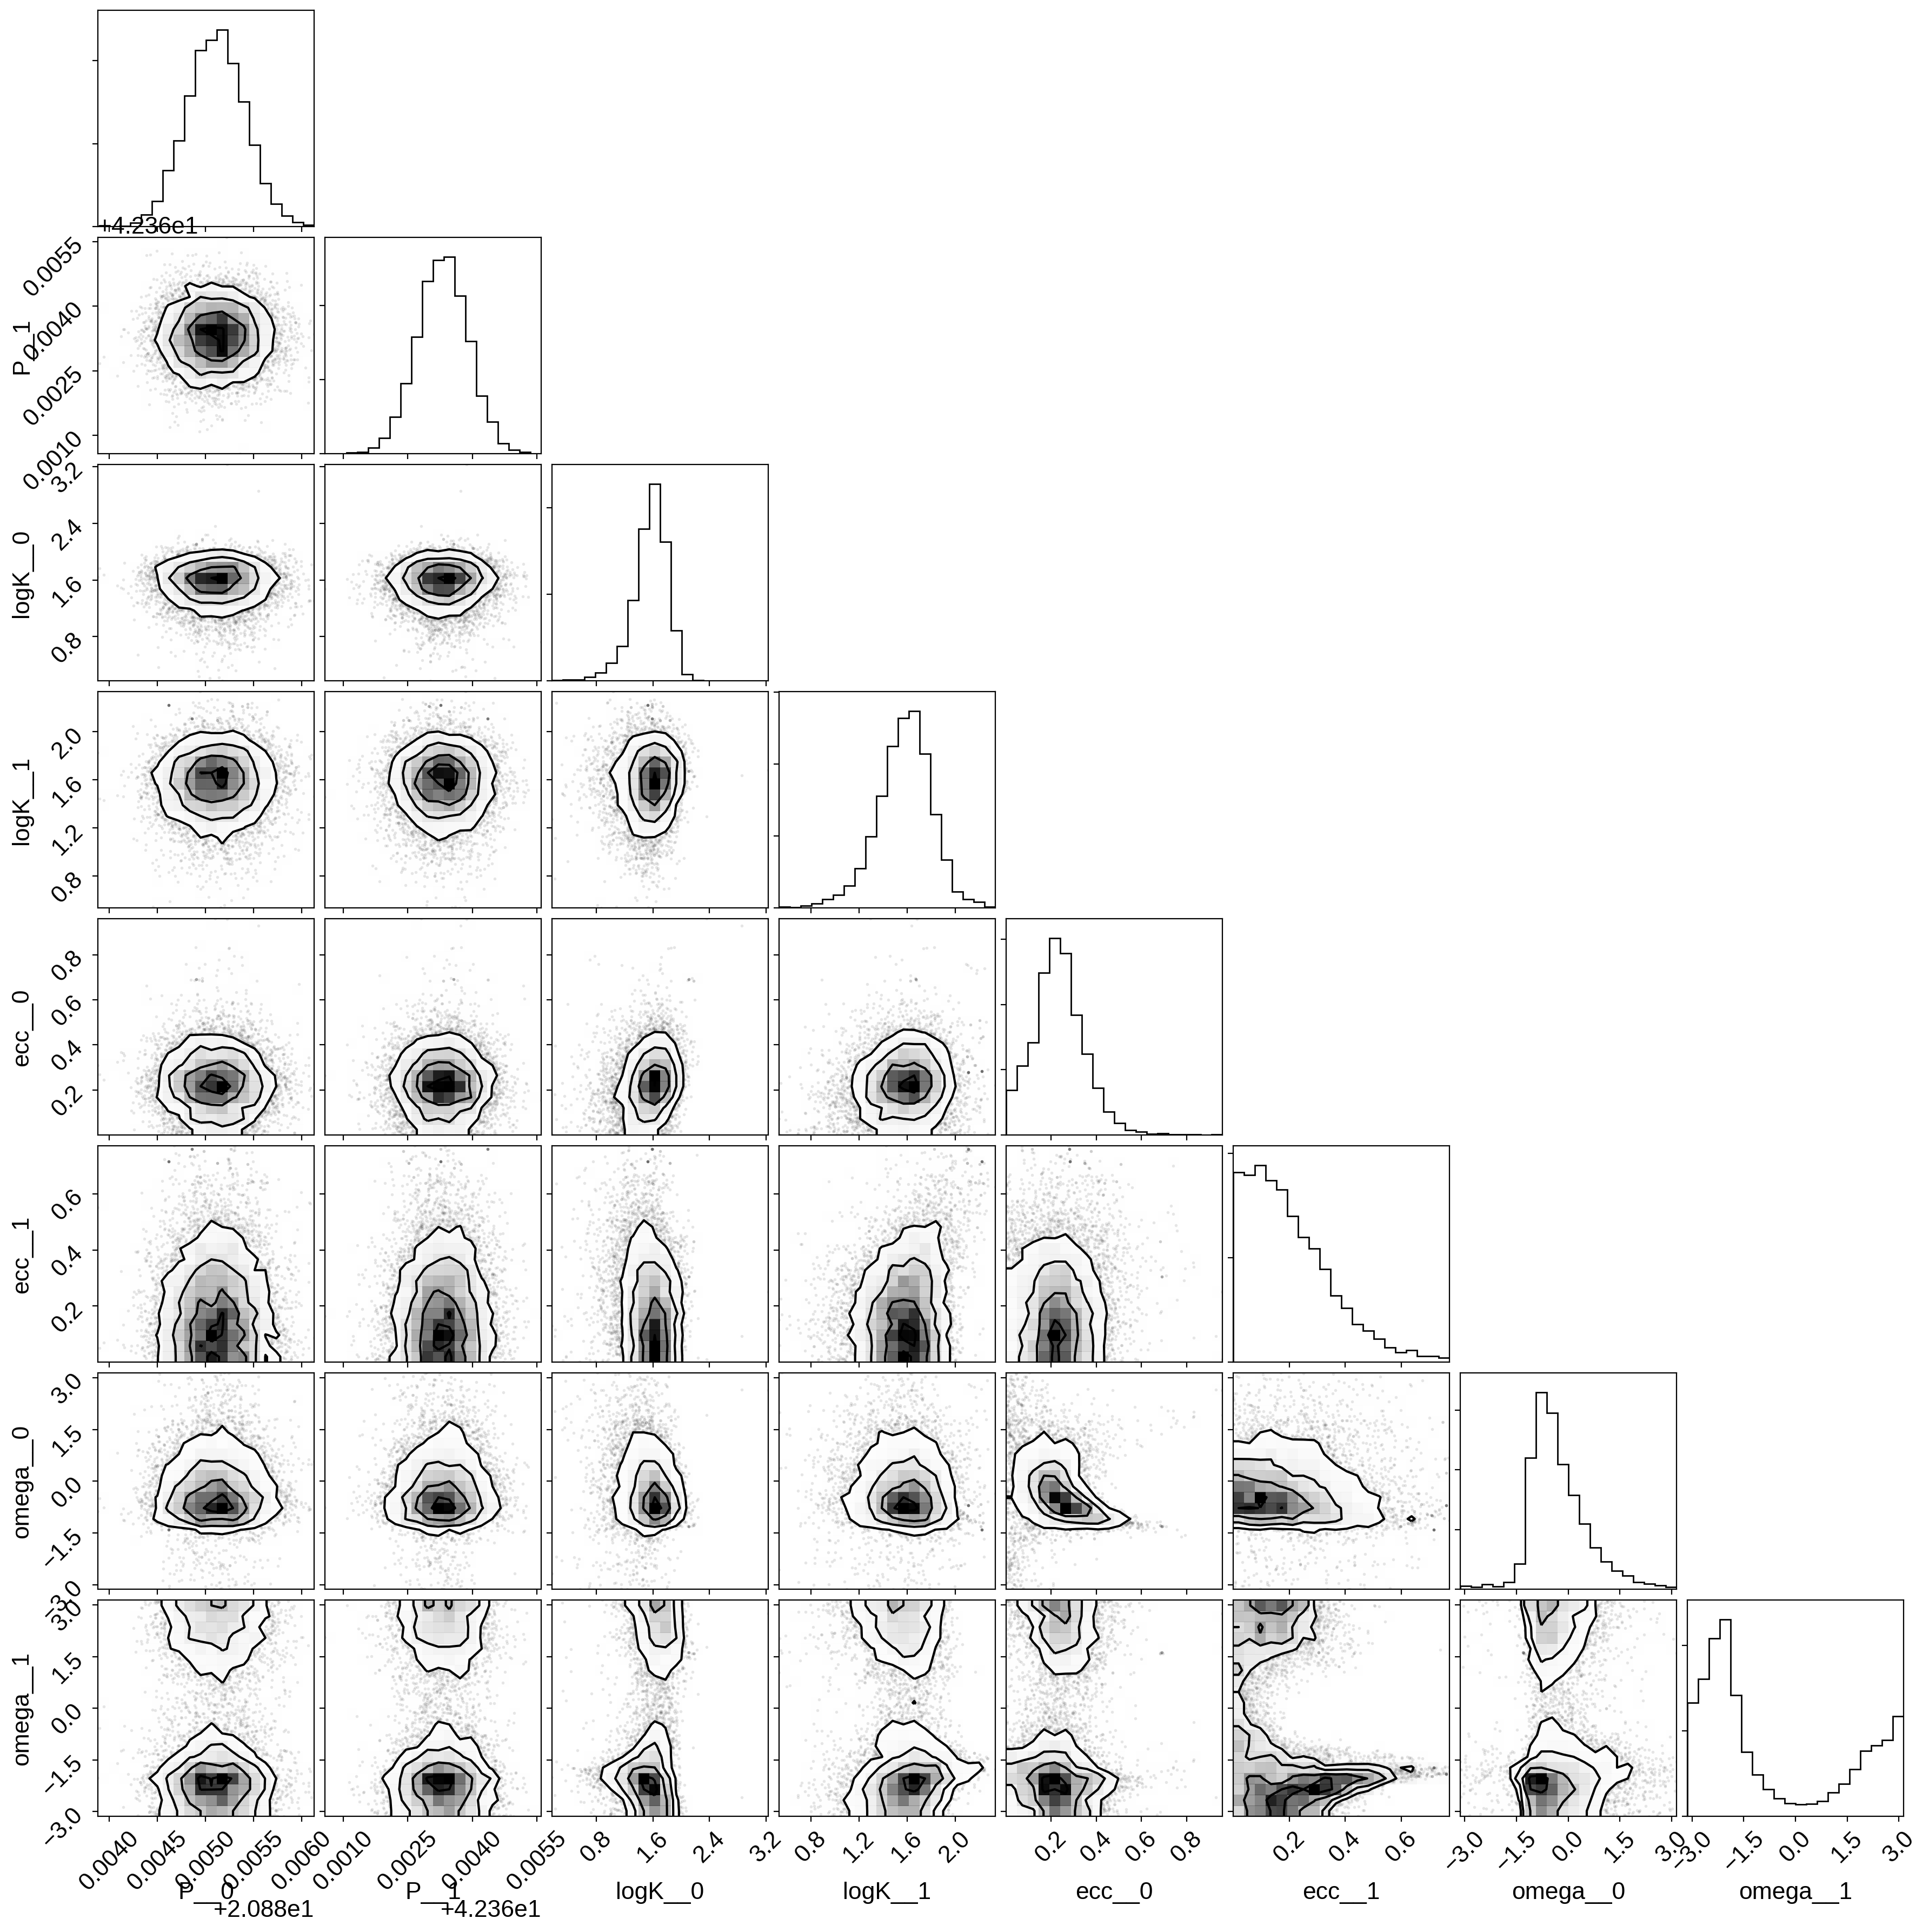

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

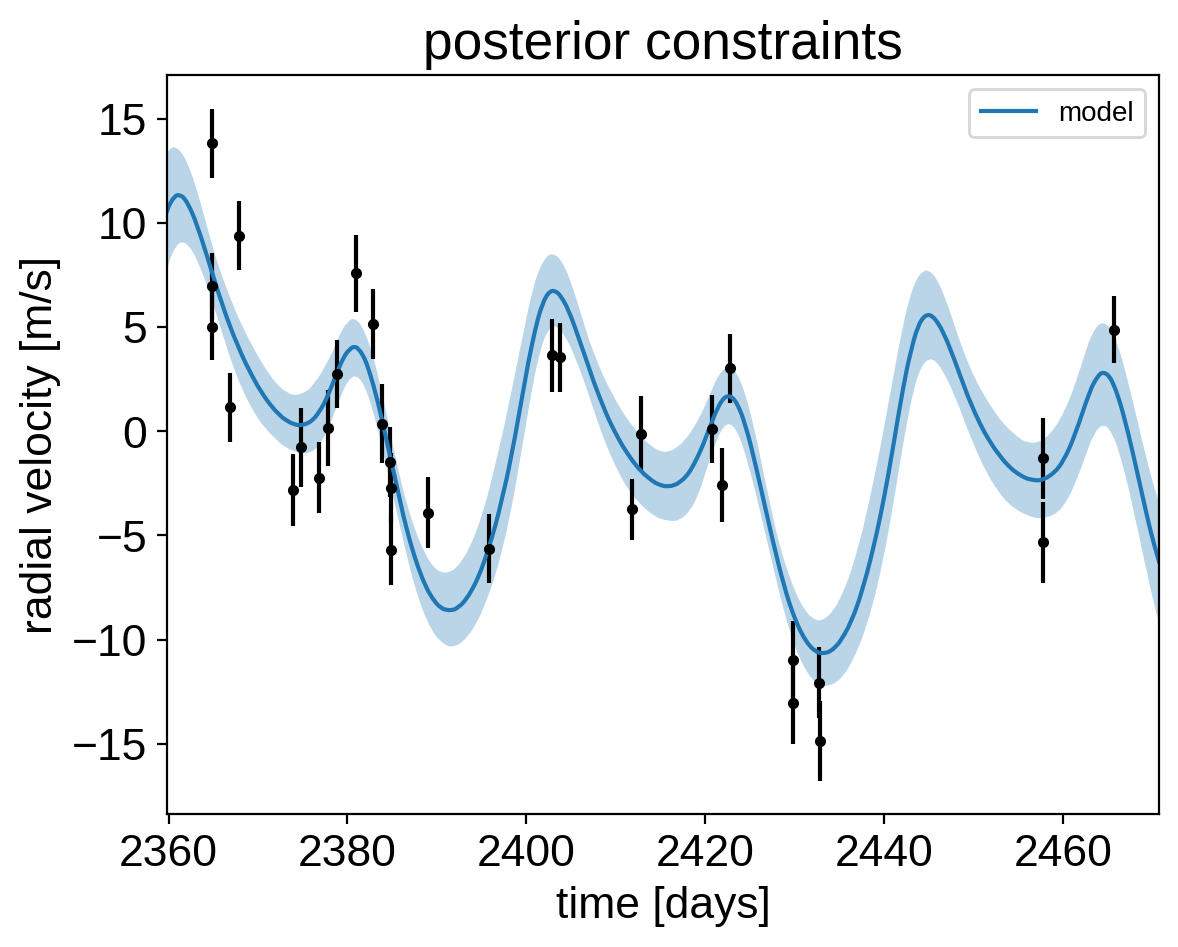

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

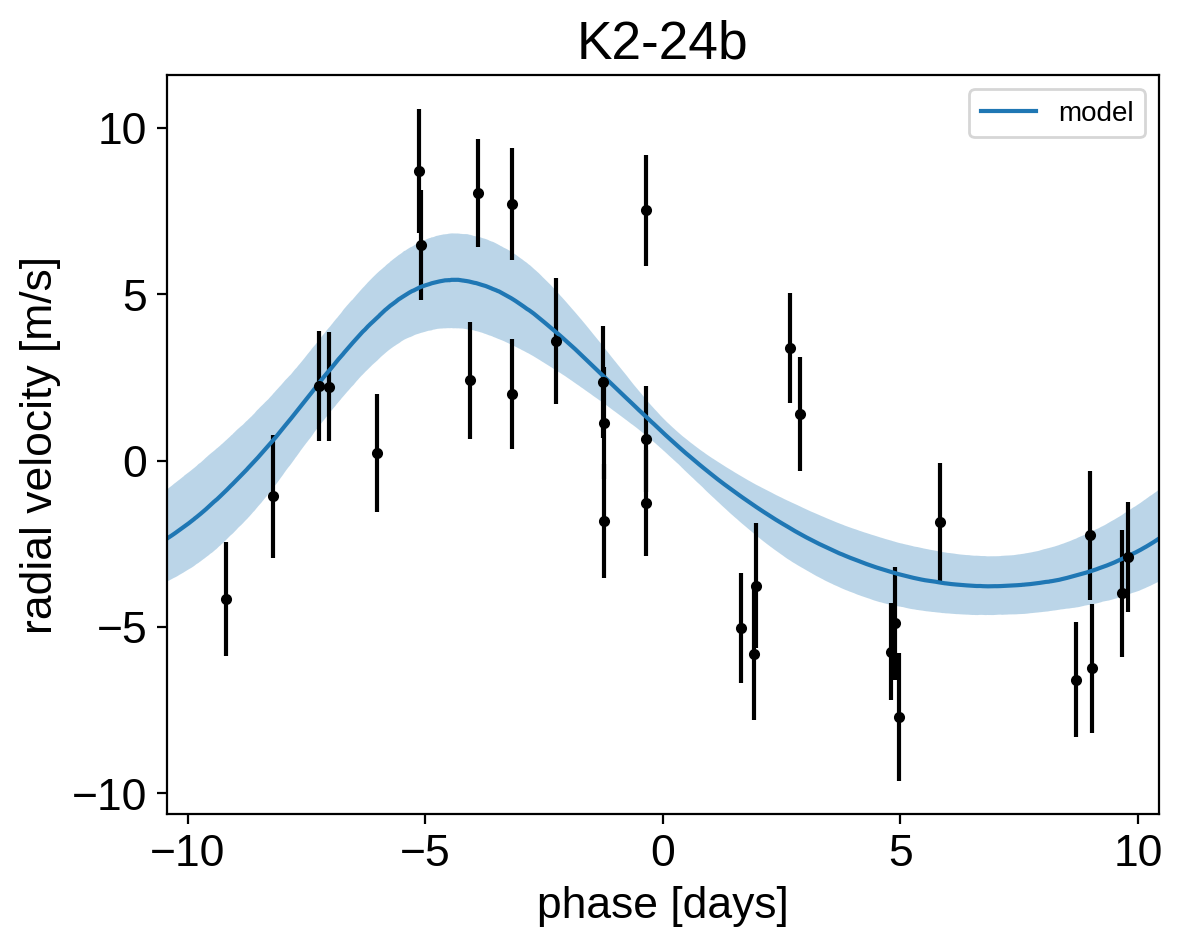

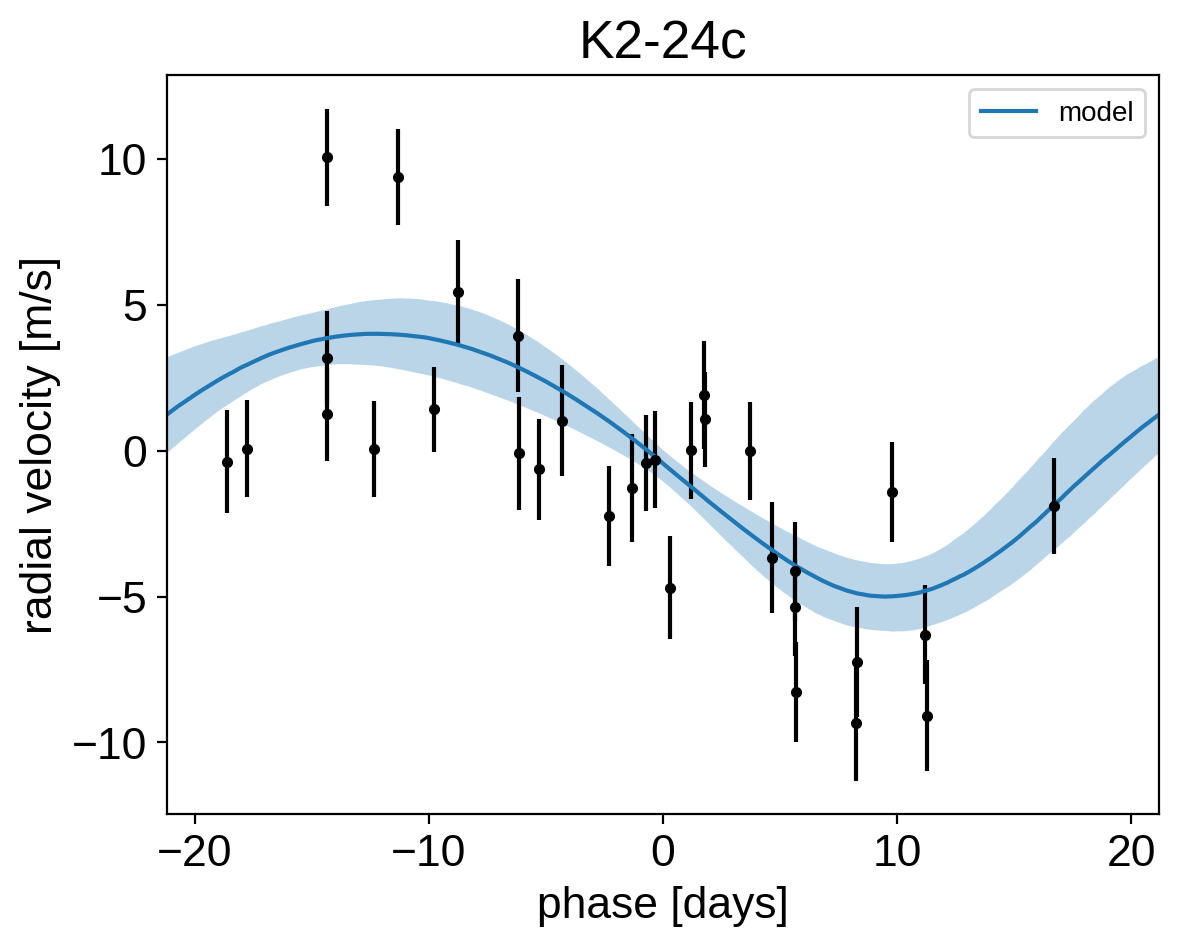

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [15]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.4},
   month = dec,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
